# Data Mining Project - Group XX 2025/2026

# Import Libraries

In [25]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from itertools import product
from ydata_profiling import ProfileReport

# for better resolution plots
%config InlineBackend.figure_format = 'retina'

#o svg consegue ampliar infinitamente os gráficos sem perder qualidade mas às vezes é mais lento 
#por isso agora usamos retina

np.random.seed(40311)
sns.set()

# Loading the Data

Import the datasets from csv files using commas as separators of the columns and setting the unique customer identifier as the index of both columns.

In [26]:
flightsDB = pd.read_csv('data/DM_AIAI_FlightsDB.csv', sep = ",", index_col= "Loyalty#")
customerDB = pd.read_csv('data/DM_AIAI_CustomerDB.csv', sep = ",", index_col= "Loyalty#")
metaData = pd.read_csv('data/DM_AIAI_Metadata.csv', sep = ";", header= None)

Remove the 'Unnamed' column referring to a sequential numbering of the rows, as we set the column "Loyalty#" as the index

In [27]:
customerDB = customerDB.iloc[:, 1:]
customerDB

,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
Loyalty#,,,,,,,,,,,,,,,,,,,
480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,NaN,3839.14,Standard
549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,male,College,Rural,0.0,Divorced,Star,3/9/2019,NaN,3839.61,Standard
429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard
608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,male,College,Suburban,0.0,Single,Star,2/17/2016,NaN,3839.75,Standard
530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,male,Bachelor,Suburban,97832.0,Married,Star,10/25/2017,NaN,3842.79,2021 Promotion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100012,Ethan,Thompson,Ethan Thompson,Canada,Quebec,Quebec City,46.759733,-71.141009,Y0C 7D6,male,Bachelor,Suburban,NaN,Single,Star,2/27/2019,2/27/2019,NaN,Standard
100013,Layla,Young,Layla Young,Canada,Alberta,Edmonton,53.524829,-113.546357,L3S 9Y3,female,Bachelor,Rural,NaN,Married,Star,9/20/2017,9/20/2017,NaN,Standard
100014,Amelia,Bennett,Amelia Bennett,Canada,New Brunswick,Moncton,46.051866,-64.825428,G2S 2B6,male,Bachelor,Rural,NaN,Married,Star,11/28/2020,11/28/2020,NaN,Standard


# Metadata

**FlightsDB Database Variable Description**
- **Loyalty#:**	Unique customer identifier linking to CustomerDB
- **Year:**	Year of flight activity record
- **Month:**	Month of flight activity record (1-12)
- **YearMonthDate:**	First day of the month for the activity period
- **NumFlights:**	Total number of flights taken by customer in the month
- **NumFlightsWithCompanions:**	Number of flights where customer traveled with companions
- **DistanceKM:**	Total distance traveled in kilometers for the month
- **PointsAccumulated:**	Loyalty points earned by customer during the month
- **PointsRedeemed:**	Loyalty points spent/redeemed by customer during the month
- **DollarCostPointsRedeemed:**	Dollar value of points redeemed during the month

**CustomerDB Database Variable Description**
- **Loyalty#:**  Unique customer identifier for loyalty program members
- **First Name:**   Customer's first name
- **Last Name:**   Customer's last name 
- **Customer Name:** Customer's full name (concatenated)
- **Country:**	Customer's country of residence
- **Province or State:**	Customer's province or state
- **City:**	Customer's city of residence
- **Latitude:**	Geographic latitude coordinate of customer location
- **Longitude:**	Geographic longitude coordinate of customer locatio
- **Postal code:**	Customer's postal/ZIP code
- **Gender:**	Customer's gender
- **Education:**	Customer's highest education level (Bachelor, College, etc.)
- **Location:** Code	Urban/Suburban/Rural classification of customer residence
- **Income:**	Customer's annual income
- **Marital Status:**	Customer's marital status (Married, Single, Divorced)
- **LoyaltyStatus:**	Current tier status in loyalty program (Star > Nova > Aurora)
- **EnrollmentDateOpening:**	Date when customer joined the loyalty program
- **CancellationDate:**	Date when customer left the program
- **Customer Lifetime:** Value	Total calculated monetary value of customer relationship
- **EnrollmentType:**	Method of joining loyalty program

# Data Preparation

## Feature Engineering (FlightsDB)

Firstly, we have decided to add the following features aggregated by Loyalty# so that we have the totals of the existing features. The intent of this is to help us create even more meaningful features after and give the full picture of the existing monthly data.
- `TotalFlights:` Total number of flights taken by the customer over their entire membership period.

- `TotalFlightsWithCompanions:` Total number of flights taken with at least one companion.

- `TotalDistanceKM:` Total distance flown (in kilometers) across all flights taken by the customer.

- `TotalPointsAccumulated:` Total loyalty points earned throughout the customer’s history.

- `TotalPointsRedeemed:` Total loyalty points redeemed by the customer.

- `FlightsVariance:` Variance or standard deviation of number of flights per customer over time. Calculated as groupby(Loyalty#)['NumFlights'].var(). Measures consistency in travel patterns.


In [28]:
# Convert YearMonthDate to datetime
flightsDB['YearMonthDate'] = pd.to_datetime(flightsDB['YearMonthDate'])

# Make Loyalty# a column
flightsDB_reset = flightsDB.reset_index()

# Aggregate by customer (lifetime summary metrics) and rename in one step
flights_new = (
    flightsDB_reset.groupby('Loyalty#', as_index=False)  # keep Loyalty# as a column
    .agg(
        TotalFlights=('NumFlights', 'sum'),
        TotalFlightsWithCompanions=('NumFlightsWithCompanions', 'sum'),
        TotalDistanceKM=('DistanceKM', 'sum'),
        TotalPointsAccumulated=('PointsAccumulated', 'sum'),
        TotalPointsRedeemed=('PointsRedeemed', 'sum'),
        FlightsVariance=('NumFlights', 'var')
    )
)

# Preview
flights_new.describe().T


,count,mean,std,min,25%,50%,75%,max
Loyalty#,16737.0,549735.880445,258912.132453,100018.0,326603.000000,550434.000000,772019.0000,9.999860e+05
TotalFlights,16737.0,142.070443,82.116992,0.0,70.300000,163.000000,203.6000,5.394000e+02
TotalFlightsWithCompanions,16737.0,35.769086,23.797292,0.0,16.000000,36.800000,52.8000,1.447000e+02
TotalDistanceKM,16737.0,288616.904816,166916.274539,0.0,144081.000000,331589.400000,413994.2000,1.059681e+06
TotalPointsAccumulated,16737.0,28856.006327,16688.825594,0.0,14405.000000,33152.440000,41393.5200,1.059516e+05
TotalPointsRedeemed,16737.0,8552.045767,8751.750064,0.0,0.000000,6519.000000,13607.2000,5.752780e+04
FlightsVariance,16737.0,21.175935,10.911327,0.0,15.188635,23.298571,28.9785,5.039892e+01


We will add the following features to our model in order to better analyse and segment the customers in the future.

- `PointsRedemptionRatio:` The proportion of earned points that a customer has redeemed. Calculated as PointsRedeemed / PointsAccumulated. Shows engagement with the loyalty program and redemption behavior.

- `FlightWithCompanionRatio:` Ratio of flights where the customer traveled with companions. Calculated as NumFlightsWithCompanions / NumFlights. Reveals travel habits for group or family targeting.

- `Recency:` Number of months since the customer last took a trip. Calculated as the time difference between the dataset’s latest recorded date and the customer’s most recent active flight month. A core RFM metric used to evaluate engagement freshness and identify churn risk.

- `DistancePerFlight`: The average distance flown per flight per customer. This allows us to see which customers make short and long trips.

In [29]:
# Latest date in dataset 
latest_date = flightsDB['YearMonthDate'].max()

# Group by customer using aggregated values
#grouped = flightsDB_expanded.groupby('Loyalty#')

# PointsRedemptionRatio (Total)
flights_new['PointsRedemptionRatio'] = np.where(
    flights_new['TotalPointsAccumulated'] > 0,
    flights_new['TotalPointsRedeemed'] / flights_new['TotalPointsAccumulated'],
    0
)

# Total Flight With Companion Ratio (lifetime)
flights_new['TotalFlightWithCompanionRatio'] = np.where(
    flights_new['TotalFlights'] > 0,
    flights_new['TotalFlightsWithCompanions'] / flights_new['TotalFlights'],
    0
)

## Recency (months since last active flight)
# Compute last active flight per customer
active_flights = flightsDB[flightsDB['NumFlights'] > 0]
last_active_flight = active_flights.groupby('Loyalty#')['YearMonthDate'].max()

latest_date = flightsDB['YearMonthDate'].max()
flights_new['Recency'] = (
    (latest_date - flights_new['Loyalty#'].map(last_active_flight)).dt.days / 30
).fillna(999).astype(int)


# Total Distance per Flight
flights_new['DistancePerFlight'] = np.where(
    flights_new['TotalFlights'] > 0,
    flights_new['TotalDistanceKM'] / flights_new['TotalFlights'],
    0
)

flights_new.describe().T

,count,mean,std,min,25%,50%,75%,max
Loyalty#,16737.0,549735.880445,258912.132453,100018.0,326603.000000,550434.000000,772019.000000,9.999860e+05
TotalFlights,16737.0,142.070443,82.116992,0.0,70.300000,163.000000,203.600000,5.394000e+02
TotalFlightsWithCompanions,16737.0,35.769086,23.797292,0.0,16.000000,36.800000,52.800000,1.447000e+02
TotalDistanceKM,16737.0,288616.904816,166916.274539,0.0,144081.000000,331589.400000,413994.200000,1.059681e+06
TotalPointsAccumulated,16737.0,28856.006327,16688.825594,0.0,14405.000000,33152.440000,41393.520000,1.059516e+05
TotalPointsRedeemed,16737.0,8552.045767,8751.750064,0.0,0.000000,6519.000000,13607.200000,5.752780e+04
FlightsVariance,16737.0,21.175935,10.911327,0.0,15.188635,23.298571,28.978500,5.039892e+01
PointsRedemptionRatio,16737.0,0.287281,0.484801,0.0,0.000000,0.215097,0.419533,3.326772e+01
TotalFlightWithCompanionRatio,16737.0,0.235125,0.135974,0.0,0.163934,0.237791,0.308725,1.000000e+00
Recency,16737.0,90.754496,285.102694,0.0,0.000000,0.000000,1.000000,9.990000e+02


### Selecting Created Features

To avoid creating redundant features, we will quickly analyse their correlation and drop the irrelevant ones.

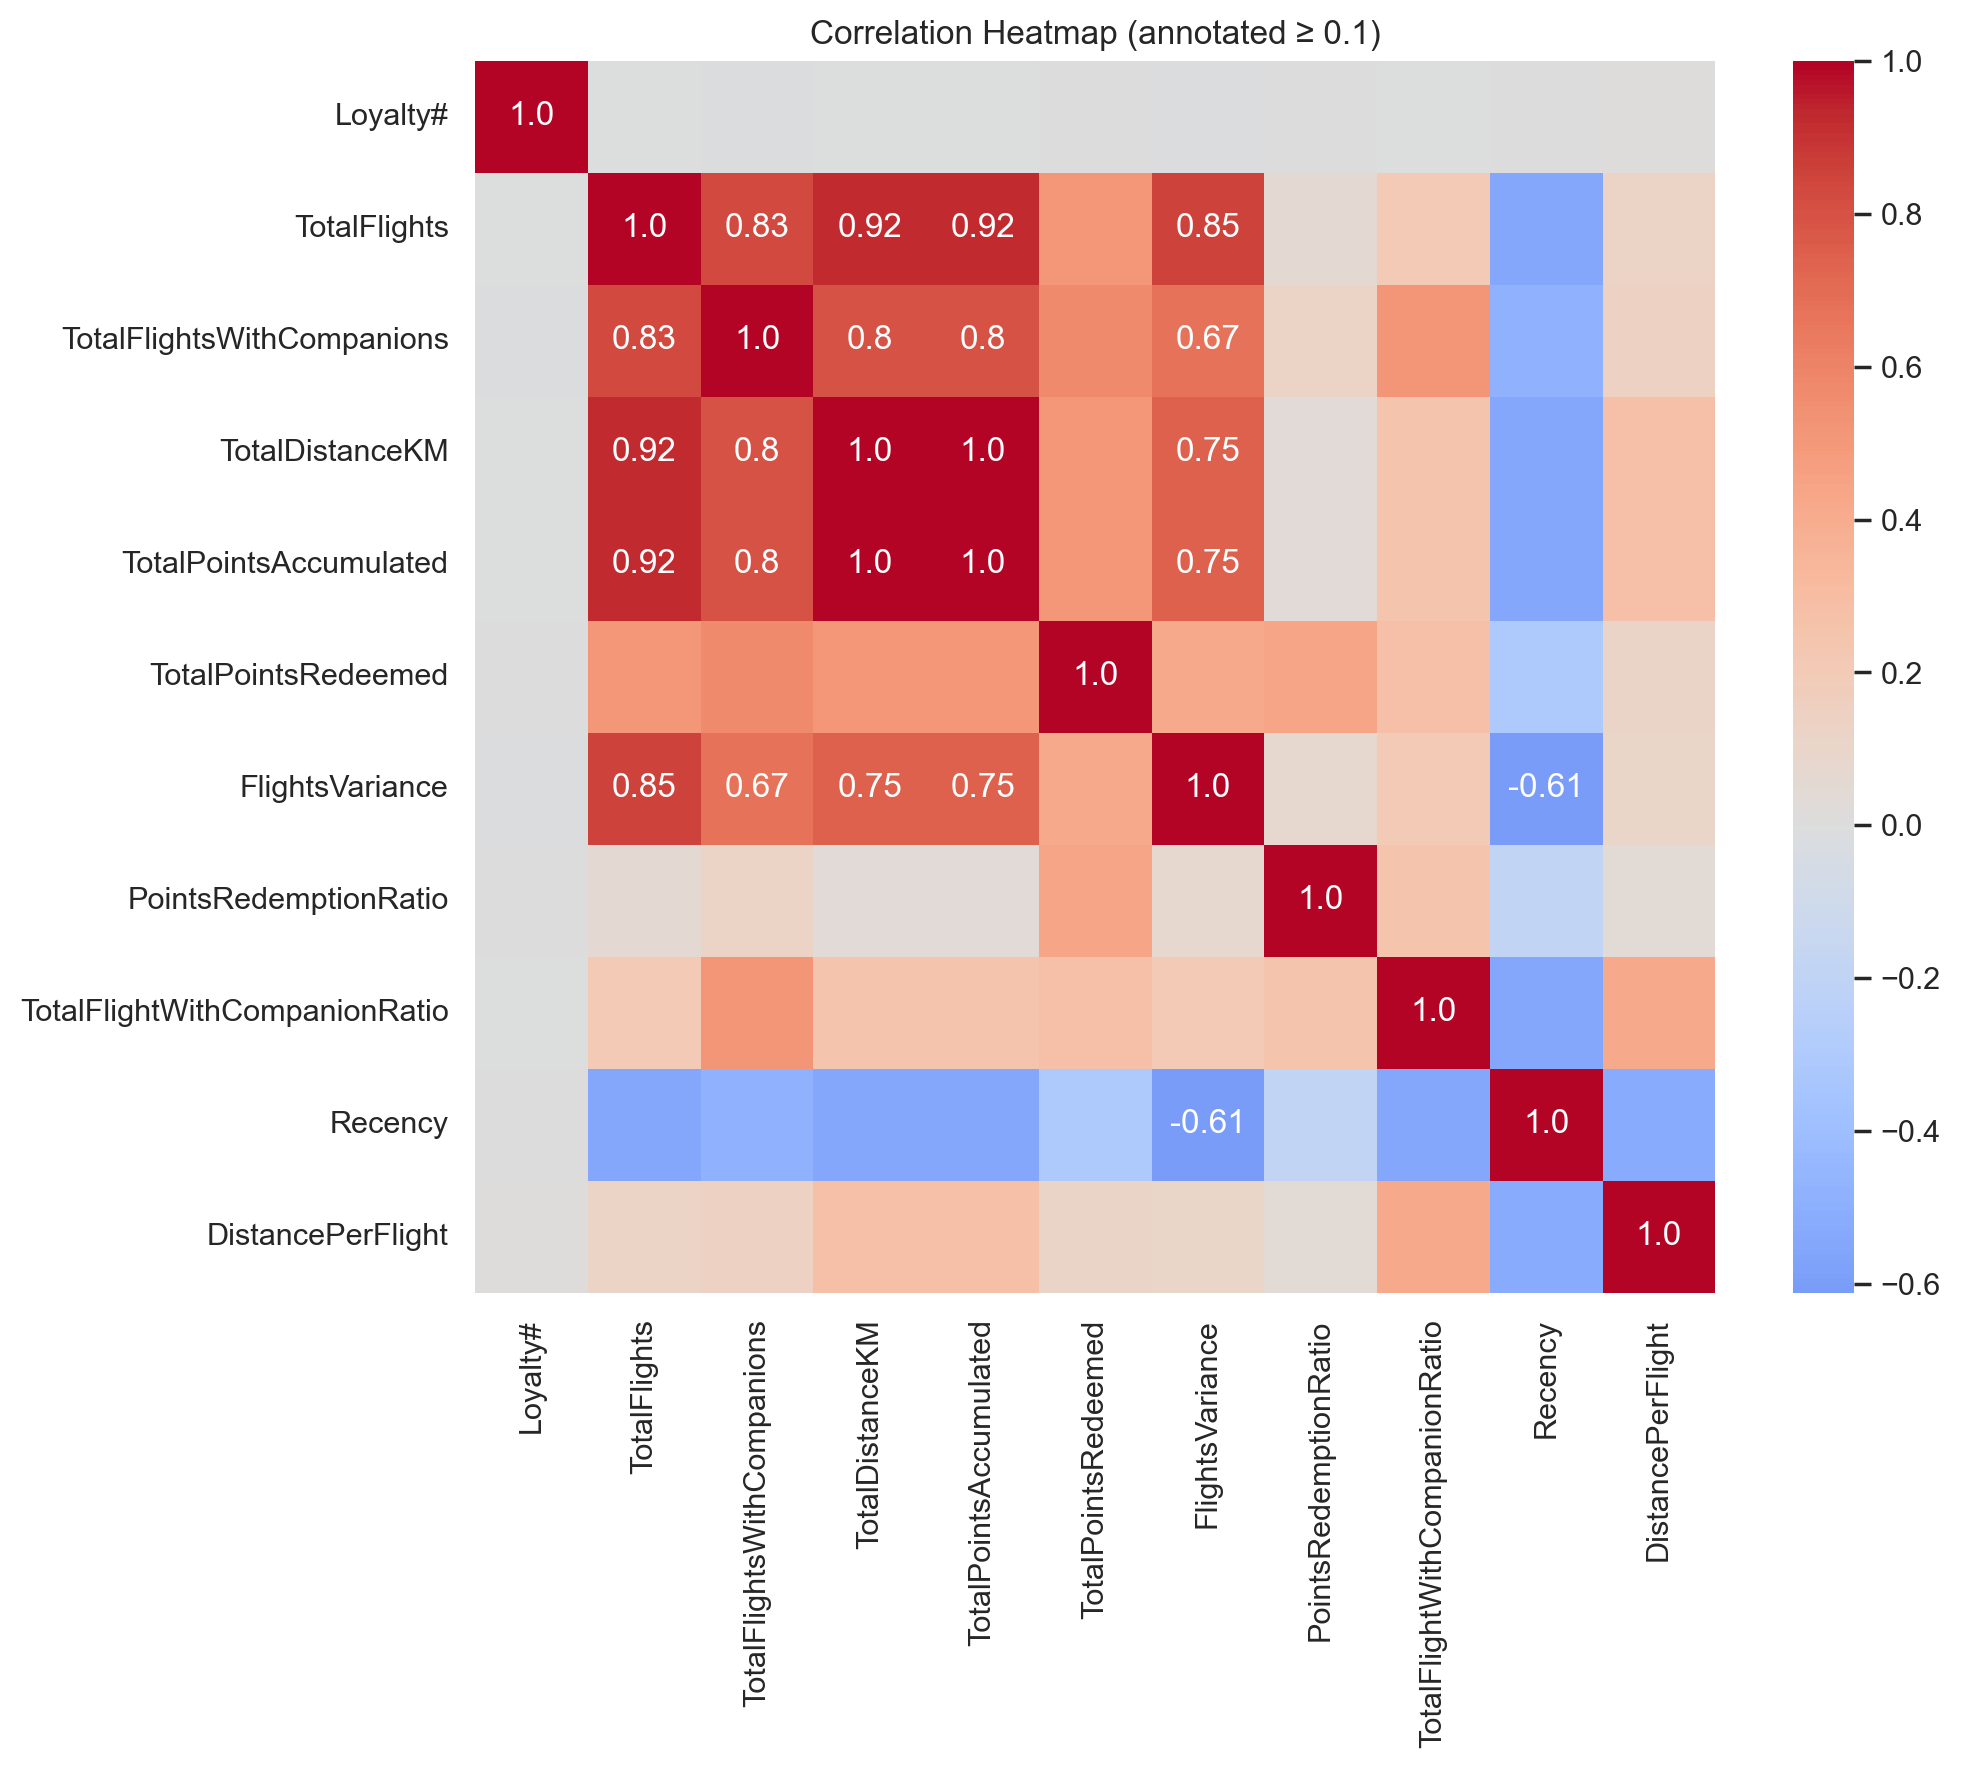

In [30]:
# Compute correlation matrix
corr = flights_new.corr()

# Mask values < 0.5
mask_annot = np.abs(corr.values) >= 0.6
annot = np.where(mask_annot, np.round(corr.values, 2), "")

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(data=corr, annot=annot, fmt="", center=0, cmap="coolwarm")
plt.title("Correlation Heatmap (annotated ≥ 0.1)")
plt.show()


In [31]:
flights_new = flights_new.drop(columns=[
    'TotalFlights',
    'TotalFlightsWithCompanions',
    'TotalDistanceKM',
    'TotalPointsAccumulated'
], errors='ignore')

flights_new.describe().T


,count,mean,std,min,25%,50%,75%,max
Loyalty#,16737.0,549735.880445,258912.132453,100018.0,326603.000000,550434.000000,772019.000000,999986.000000
TotalPointsRedeemed,16737.0,8552.045767,8751.750064,0.0,0.000000,6519.000000,13607.200000,57527.800000
FlightsVariance,16737.0,21.175935,10.911327,0.0,15.188635,23.298571,28.978500,50.398921
PointsRedemptionRatio,16737.0,0.287281,0.484801,0.0,0.000000,0.215097,0.419533,33.267717
TotalFlightWithCompanionRatio,16737.0,0.235125,0.135974,0.0,0.163934,0.237791,0.308725,1.000000
Recency,16737.0,90.754496,285.102694,0.0,0.000000,0.000000,1.000000,999.000000
DistancePerFlight,16737.0,1950.286158,1164.231403,0.0,1626.101519,1977.915299,2334.653830,31875.000000


In [32]:
flights_new.columns

Index(['Loyalty#', 'TotalPointsRedeemed', 'FlightsVariance',
       'PointsRedemptionRatio', 'TotalFlightWithCompanionRatio', 'Recency',
       'DistancePerFlight'],
      dtype='object')

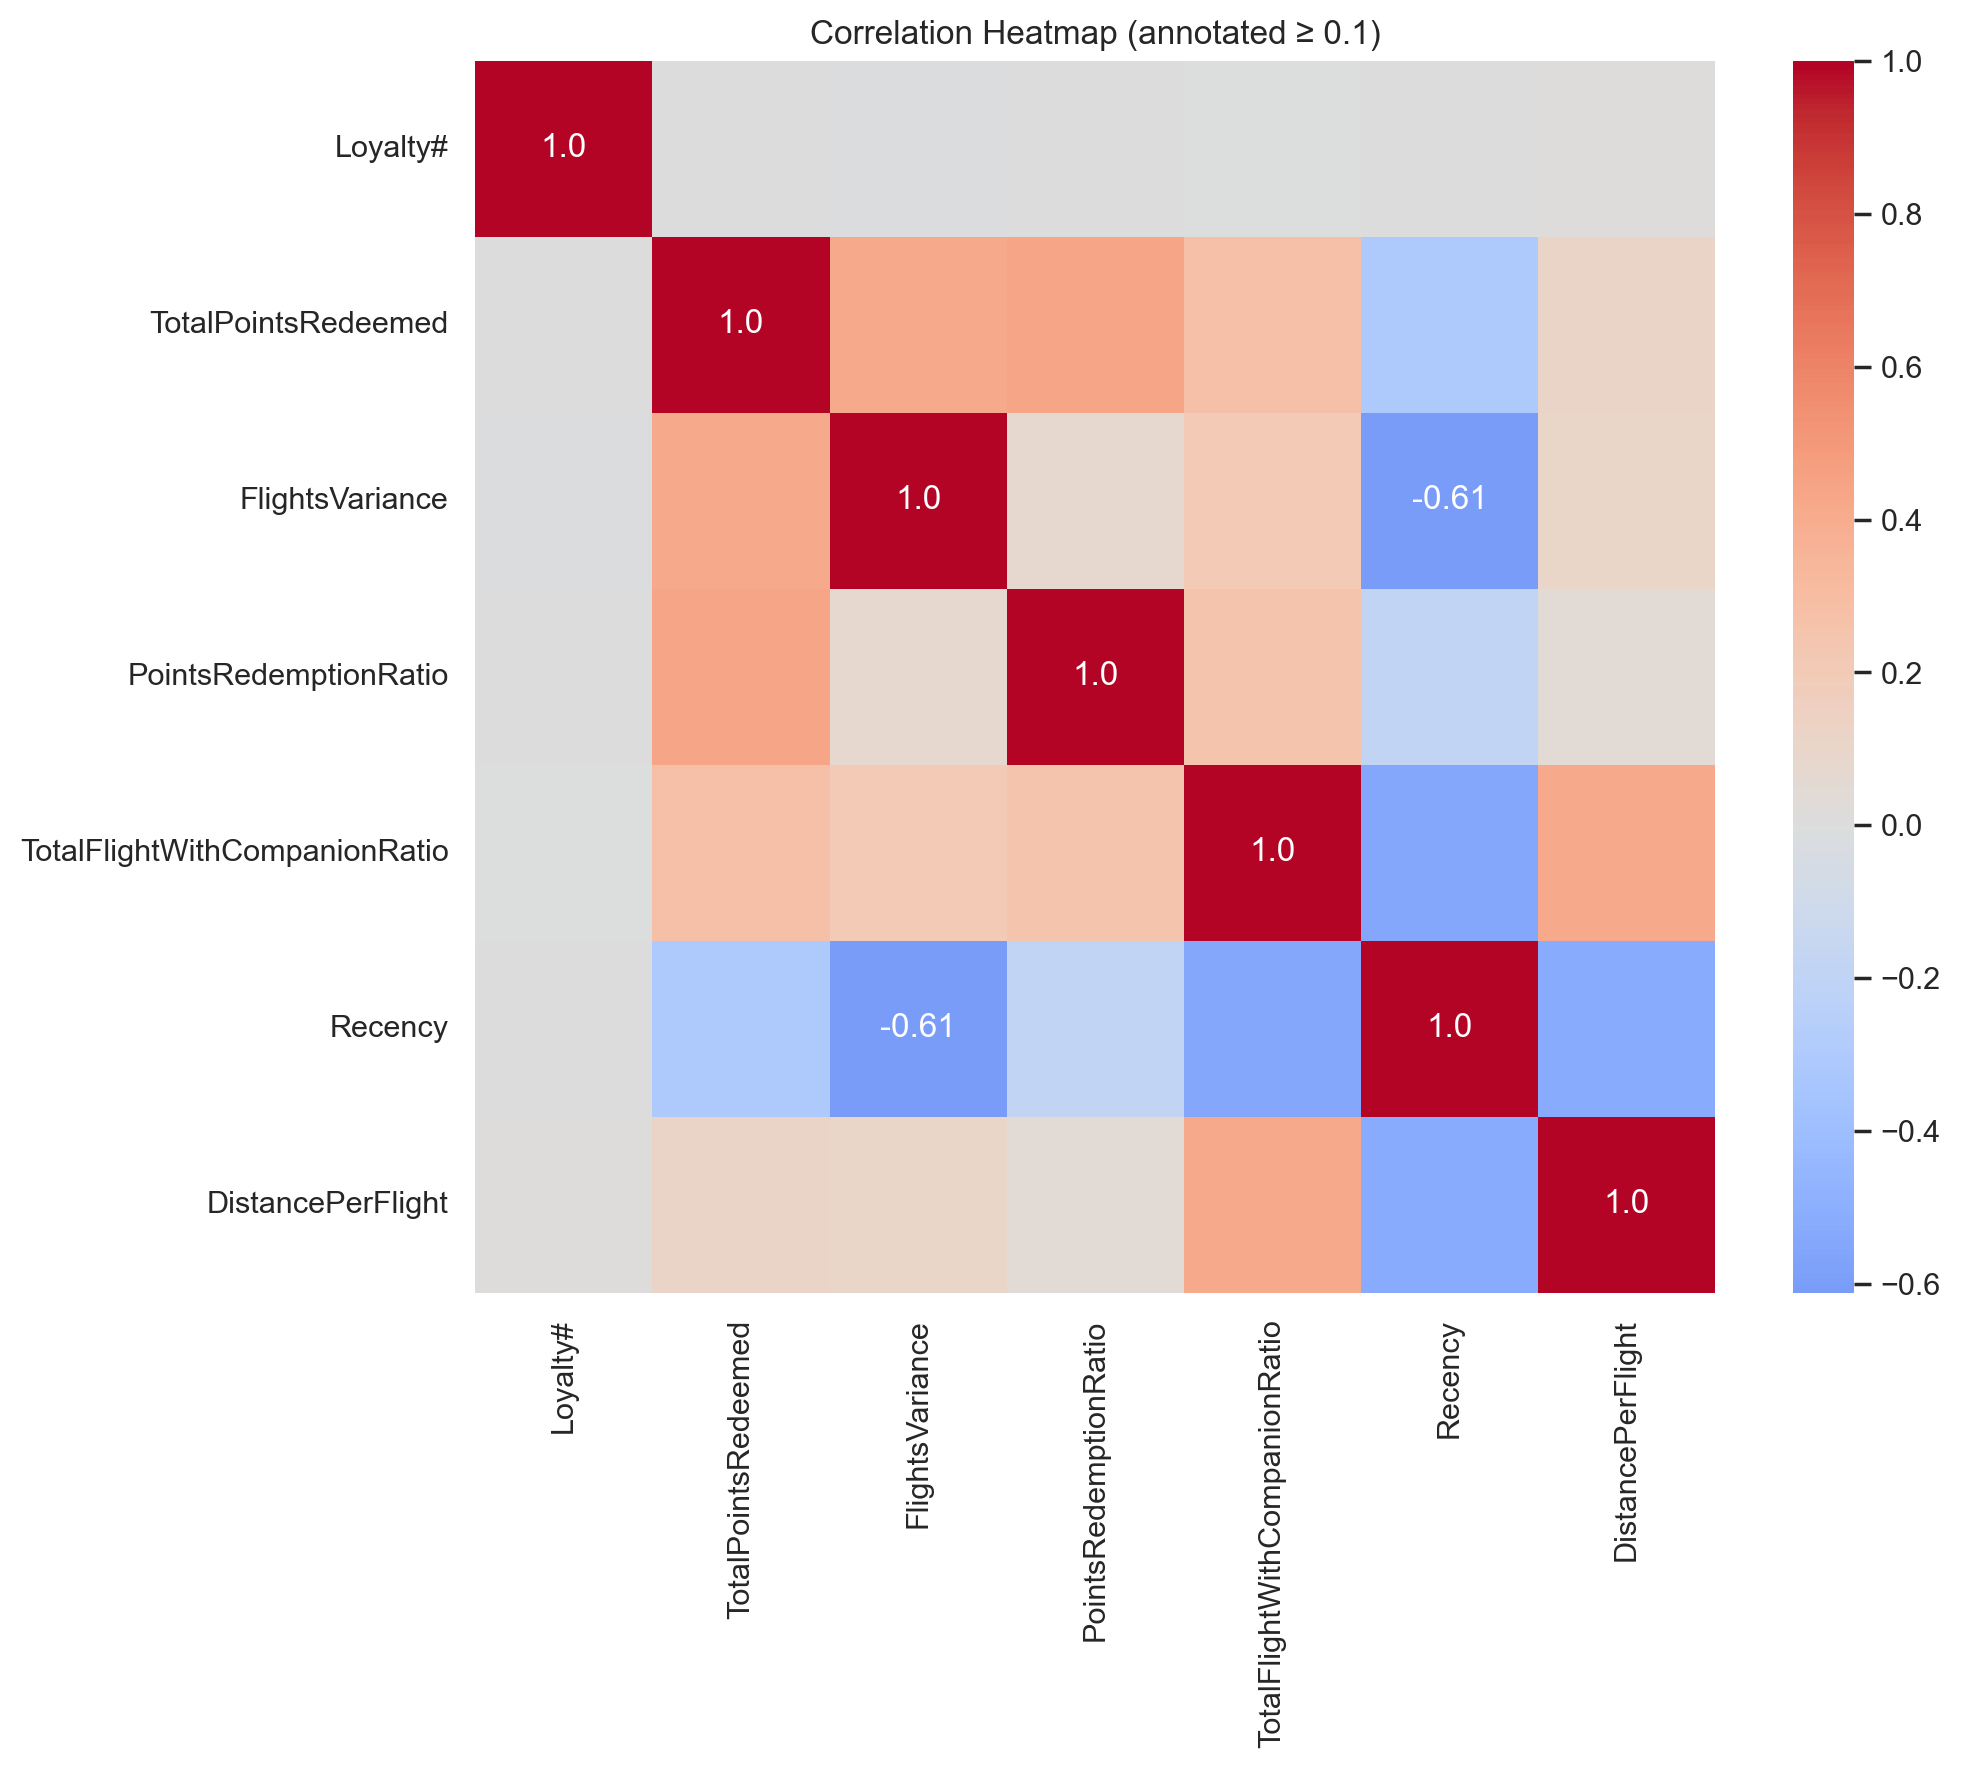

In [33]:
# Compute correlation matrix
corr = flights_new.corr()

# Mask values < 0.5
mask_annot = np.abs(corr.values) >= 0.6
annot = np.where(mask_annot, np.round(corr.values, 2), "")

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(data=corr, annot=annot, fmt="", center=0, cmap="coolwarm")
plt.title("Correlation Heatmap (annotated ≥ 0.1)")
plt.show()


In [34]:
flightsDB_expanded = pd.DataFrame(flightsDB_new[['TotalPointsRedeemed',
                                                'PointsRedemptionRatio',
                                                'TotalFlightWithCompanionRatio',
                                                'FlightsVariance',
                                                'Recency',
                                                'DistancePerFlight']])

NameError: name 'flightsDB_new' is not defined

## Feature Engineering (CustomerDB)

We have decided to add the following features to help us segment the customers later on.
- `IncomeBins:` Groups customers into discrete income categories ranging from low to very high.

- `HouseholdType:` Combined indicator describing both marital status and location type of the customer.

- `MonthsSinceEnrollment:` Number of months since the customer joined the loyalty program.

- `IsActive:` Indicates whether the customer is currently active in the loyalty program (no cancellation date).

- `CLVBins:` Categorizes customers into five groups based on their Customer Lifetime Value (CLV), from lowest to highest.

- `IncomeVsEducationMean`: Difference between the customer’s income and the average income for their education group.

- `CLVvsCityMean`: Difference between the customer’s CLV and the average CLV for their city.


In [ ]:
# Create expanded dataset
customerDB_expanded = customerDB.copy()
customerDB_new = pd.DataFrame()

# Convert enrollment and cancellation dates to datetime
customerDB['EnrollmentDateOpening'] = pd.to_datetime(customerDB_expanded['EnrollmentDateOpening'], errors='coerce')

# Today reference (or max date from flightsDB if preferred)
reference_date = pd.Timestamp.today()

## INCOME BINS
# Fill NaNs temporarily with -1
income_nonan = customerDB_expanded['Income'].fillna(-1)

# Compute quartiles
try:
    temp_bins = pd.qcut(income_nonan, q=4, duplicates='drop')
    bins_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High'][:len(temp_bins.cat.categories)]
    customerDB_expanded['IncomeBins'] = pd.qcut(
        income_nonan,
        q=4,
        labels=bins_labels,
        duplicates='drop'
    )
    # Replace the -1 bin with 'Unknown'
    customerDB_expanded['IncomeBins'] = customerDB_expanded['IncomeBins'].cat.add_categories(['Unknown'])
    customerDB_expanded.loc[income_nonan == -1, 'IncomeBins'] = 'Unknown'
except ValueError:
    customerDB_expanded['IncomeBins'] = pd.Series(['Unknown']*len(customerDB_expanded))
customerDB_new['IncomeBins'] = customerDB_expanded['IncomeBins']


# HouseholdType → Marital + Location
customerDB_expanded['HouseholdType'] = (
    customerDB_expanded['Location Code'].fillna('Unknown') + '-' +
    customerDB_expanded['Marital Status'].fillna('Unknown')
)
customerDB_new['HouseholdType'] = customerDB_expanded['HouseholdType']

# MonthsSinceEnrollment
customerDB_expanded['MonthsSinceEnrollment'] = (
    (reference_date - customerDB['EnrollmentDateOpening']).dt.days / 30
).fillna(0).clip(lower=0)
customerDB_new['MonthsSinceEnrollment'] = customerDB_expanded['MonthsSinceEnrollment']

# IsActive → No cancellation = still active
customerDB_expanded['IsActive'] = customerDB_expanded['CancellationDate'].isna().astype(int)
customerDB_new['IsActive'] = customerDB_expanded['IsActive']

# Fill NaNs temporarily with -1
clv_nonan = customerDB_expanded['Customer Lifetime Value'].fillna(-1)

## CLV BINS
# Compute quartiles
try:
    temp_bins = pd.qcut(clv_nonan, q=5, duplicates='drop')
    clv_labels = ["Very Low", "Low", "Medium", "High", "Very High"][:len(temp_bins.cat.categories)]
    customerDB_expanded['CLVBins'] = pd.qcut(
        clv_nonan,
        q=5,
        labels=clv_labels,
        duplicates='drop'
    )
    # Replace the -1 bin with 'Unknown'
    customerDB_expanded['CLVBins'] = customerDB_expanded['CLVBins'].cat.add_categories(['Unknown'])
    customerDB_expanded.loc[clv_nonan == -1, 'CLVBins'] = 'Unknown'
except ValueError:
    customerDB_expanded['CLVBins'] = pd.Series(['Unknown']*len(customerDB_expanded))
customerDB_new['CLVBins'] = customerDB_expanded['CLVBins']

# ---  Income vs Education Mean ---
customerDB_expanded['IncomeVsEducationMean'] = (
    customerDB_expanded['Income'] - customerDB_expanded.groupby('Education')['Income'] \
    .transform('mean')
)
customerDB_new['IncomeVsEducationMean'] = customerDB_expanded['IncomeVsEducationMean']

# ---  CLV vs City Mean ---
customerDB_expanded['CLVvsCityMean'] = (
    customerDB_expanded['Customer Lifetime Value'] - customerDB_expanded.groupby('City')['Customer Lifetime Value'] \
    .transform('mean')
)
customerDB_new['CLVvsCityMean'] = customerDB_expanded['CLVvsCityMean']

# Preview result
customerDB_expanded.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
First Name,16921,4941,Deon,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Last Name,16921,15404,Salberg,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer Name,16921,16921,Cecilia Householder,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,16921,1,Canada,16921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Province or State,16921,11,Ontario,5468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,16921,29,Toronto,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,16921.0,NaN,NaN,NaN,47.1745,3.307971,42.984924,44.231171,46.087818,49.28273,60.721188
Longitude,16921.0,NaN,NaN,NaN,-91.814768,22.242429,-135.05684,-120.23766,-79.383186,-74.596184,-52.712578
Postal code,16921,75,V6E 3D9,917,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,16921,2,female,8497,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Selecting Created Features

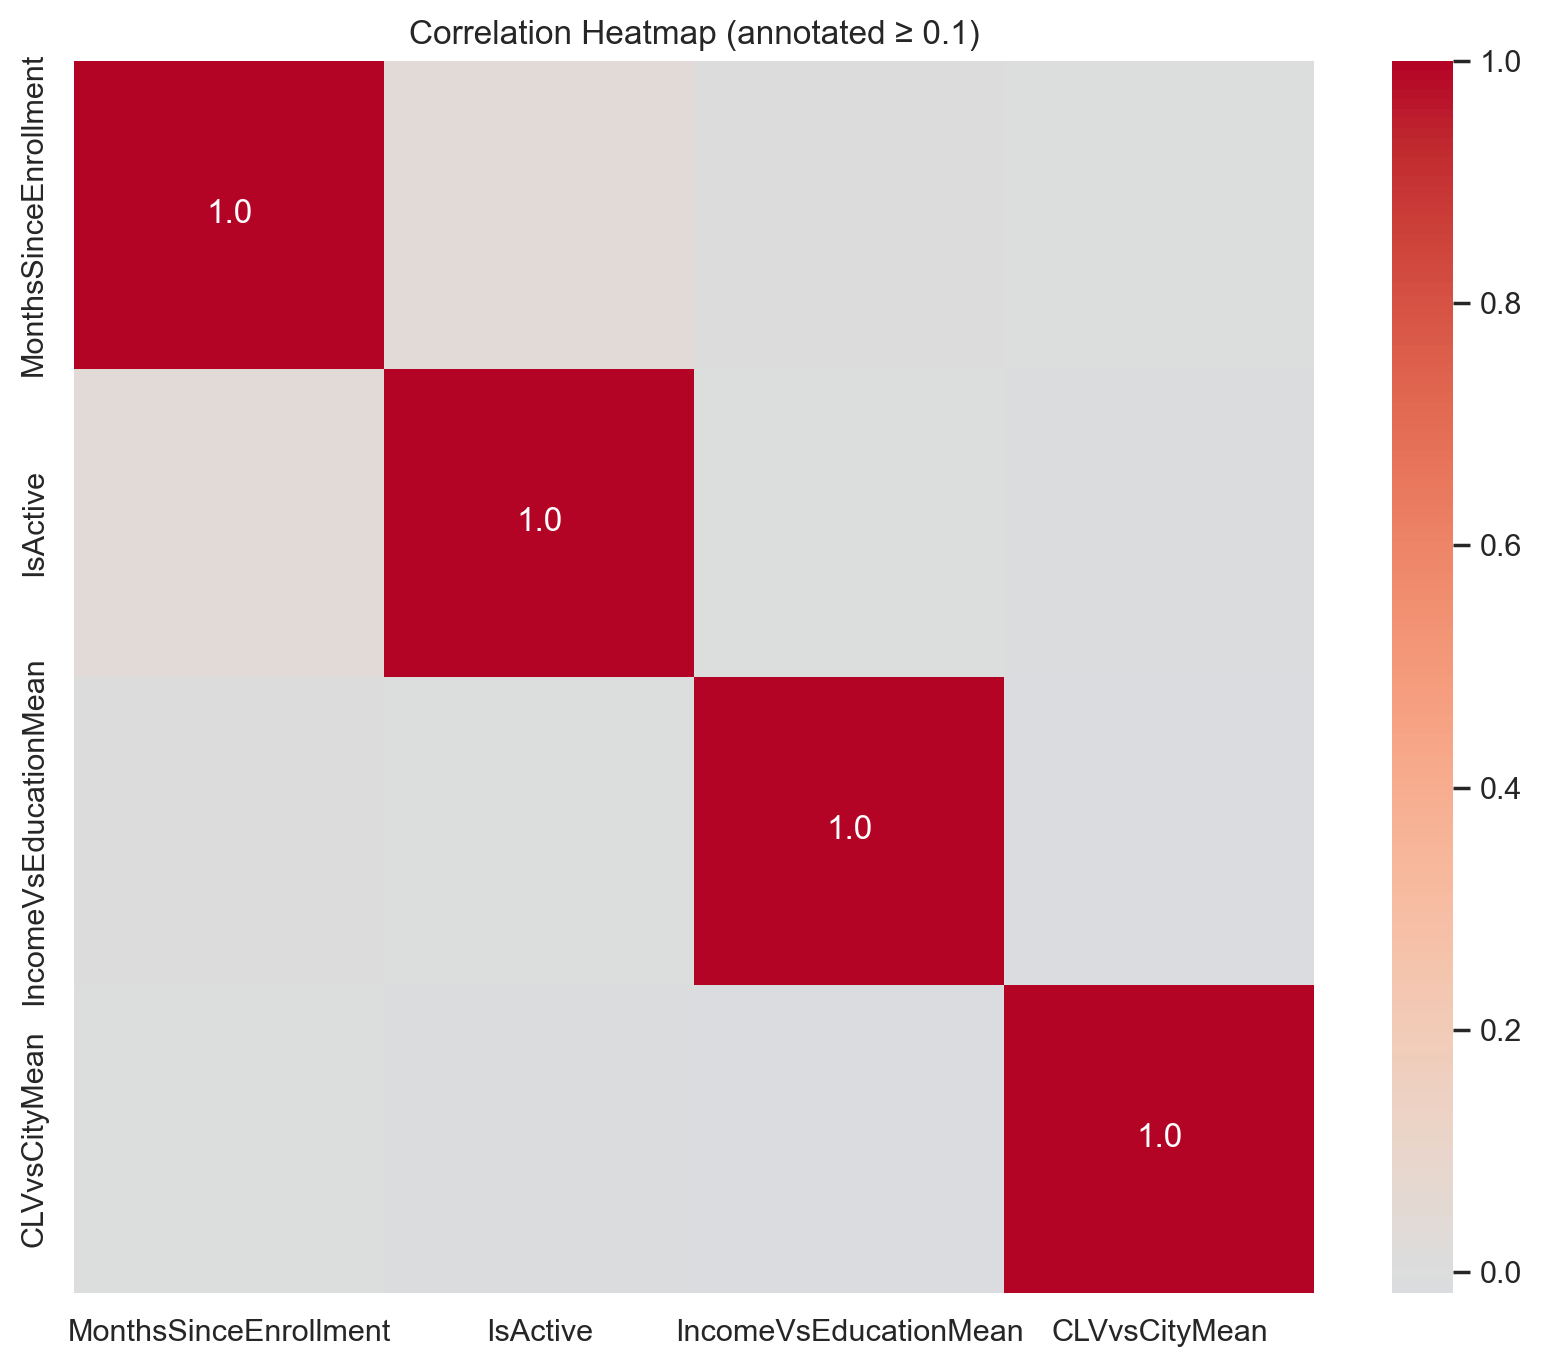

In [ ]:
customerDB_new_cont = customerDB_new.select_dtypes(include=[np.number])

# Compute correlation matrix
corr = customerDB_new_cont.corr()

# Mask values > 0.6
mask_annot = np.abs(corr.values) >= 0.6
annot = np.where(mask_annot, np.round(corr.values, 2), "")

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(data=corr, annot=annot, fmt="", center=0, cmap="coolwarm")
plt.title("Correlation Heatmap (annotated ≥ 0.1)")
plt.show()


## Feature Engineering with Merged Datasets

### Merge Datasets

In [ ]:
# Create a second expanded flightsDB, keeping only one row per customer with aggregated features
flightsDB_expanded2 = flightsDB.merge(flights_agg, on='Loyalty#', how='right')

# Merge customerDB_expanded with flightsDB_expanded2 on Loyalty#
dfs_merged = customerDB_expanded.join(flightsDB_expanded2, on="Loyalty#", how="left")

# Fill only numeric columns with 0
num_cols = dfs_merged.select_dtypes(include=['number']).columns
dfs_merged[num_cols] = dfs_merged[num_cols].fillna(0)

# Keep categorical NA values untouched

### Add Features

We have decided to add the following features to help us segment the customers later on.
- `FlightsPerMonthOfMembership:` Average number of flights a customer takes per month of membership. Calculated as TotalFlights / MonthsSinceEnrollment. Captures travel frequency relative to how long the customer has been in the program.

- `DistancePerCLV:` Total distance traveled by the customer normalized by their Customer Lifetime Value (CLV). Calculated as TotalDistanceKM / Customer Lifetime Value. Helps identify high-travel customers relative to their monetary value.

- `PointsRedeemedPerTotalCLV:` Loyalty points redeemed per dollar of CLV. Calculated as TotalPointsRedeemed / Customer Lifetime Value. Shows engagement efficiency in terms of spending vs. earned value.

- `RedemptionRateByLoyaltyStatus:` Customer’s points redemption relative to the average points redeemed for their loyalty tier. Calculated as TotalPointsRedeemed / mean(TotalPointsRedeemed per LoyaltyStatus). Captures how actively customers in a tier redeem points compared to peers.

- `DistanceTraveledByEducationLevel:` Customer’s total distance traveled relative to the average distance for their education level. Calculated as TotalDistanceKM / mean(TotalDistanceKM per Education group). Helps understand travel behavior patterns by education segment.


In [ ]:
# Defensive helper for zero-division
def safe_div(numerator, denominator):
    return (numerator / denominator).replace([np.inf, -np.inf], 0).fillna(0)


# FlightsPerMonthOfMembership
dfs_merged["FlightsPerYearOfMembership"] = safe_div(
    dfs_merged["TotalFlights"],
    dfs_merged["MonthsSinceEnrollment"]
)

# DistancePerCLV
dfs_merged["DistancePerCLV"] = safe_div(
    dfs_merged["TotalDistanceKM"],
    dfs_merged["Customer Lifetime Value"]
)

# PointsRedeemedPerCLVDollar
dollar_redeemed = flightsDB.groupby('Loyalty#')['DollarCostPointsRedeemed'].sum()
dfs_merged["PointsRedeemedPerCLVDollar"] = safe_div(
    dfs_merged["TotalPointsRedeemed"],
    dfs_merged["Loyalty#"].map(dollar_redeemed)
)

# RedemptionRateByLoyaltyStatus
loyalty_points_mean = dfs_merged.groupby("LoyaltyStatus")["TotalPointsRedeemed"].transform("mean")
dfs_merged["RedemptionRateByLoyaltyStatus"] = safe_div(
    dfs_merged["TotalPointsRedeemed"],
    loyalty_points_mean
)

# DistanceTraveledByEducationLevel
edu_distance_mean = dfs_merged.groupby("Education")["TotalDistanceKM"].transform("mean")
dfs_merged["DistanceTraveledByEducationLevel"] = safe_div(
    dfs_merged["TotalDistanceKM"],
    edu_distance_mean
)


# Final result preview
dfs_merged.describe().T


,count,mean,min,25%,50%,75%,max,std
Latitude,16921.0,47.1745,42.984924,44.231171,46.087818,49.28273,60.721188,3.307971
Longitude,16921.0,-91.814768,-135.05684,-120.23766,-79.383186,-74.596184,-52.712578,22.242429
Income,16921.0,37713.409787,0.0,0.0,34112.0,62375.0,99981.0,30378.754775
Customer Lifetime Value,16921.0,7981.015757,0.0,3971.35,5771.61,8936.82,83325.38,6864.608367
MonthsSinceEnrollment,16921.0,86.219674,46.833333,64.8,85.366667,107.1,131.133333,23.965966
IsActive,16921.0,0.863483,0.0,1.0,1.0,1.0,1.0,0.343347
IncomeVsEducationMean,16921.0,-0.0,-36388.523445,-9123.523445,0.0,7286.476555,43583.476555,17519.302264
CLVvsCityMean,16921.0,0.0,-6767.170102,-3996.415625,-2142.902095,962.220831,75236.176746,6853.83106
Loyalty#,16921.0,550197.393771,100011.0,326823.0,550896.0,772438.0,999999.0,259251.503597
Year,16921.0,1141.979138,0.0,0.0,2019.0,2020.0,2021.0,1001.376131


In [ ]:
len(dfs_merged.columns)

46

### Select Created Features

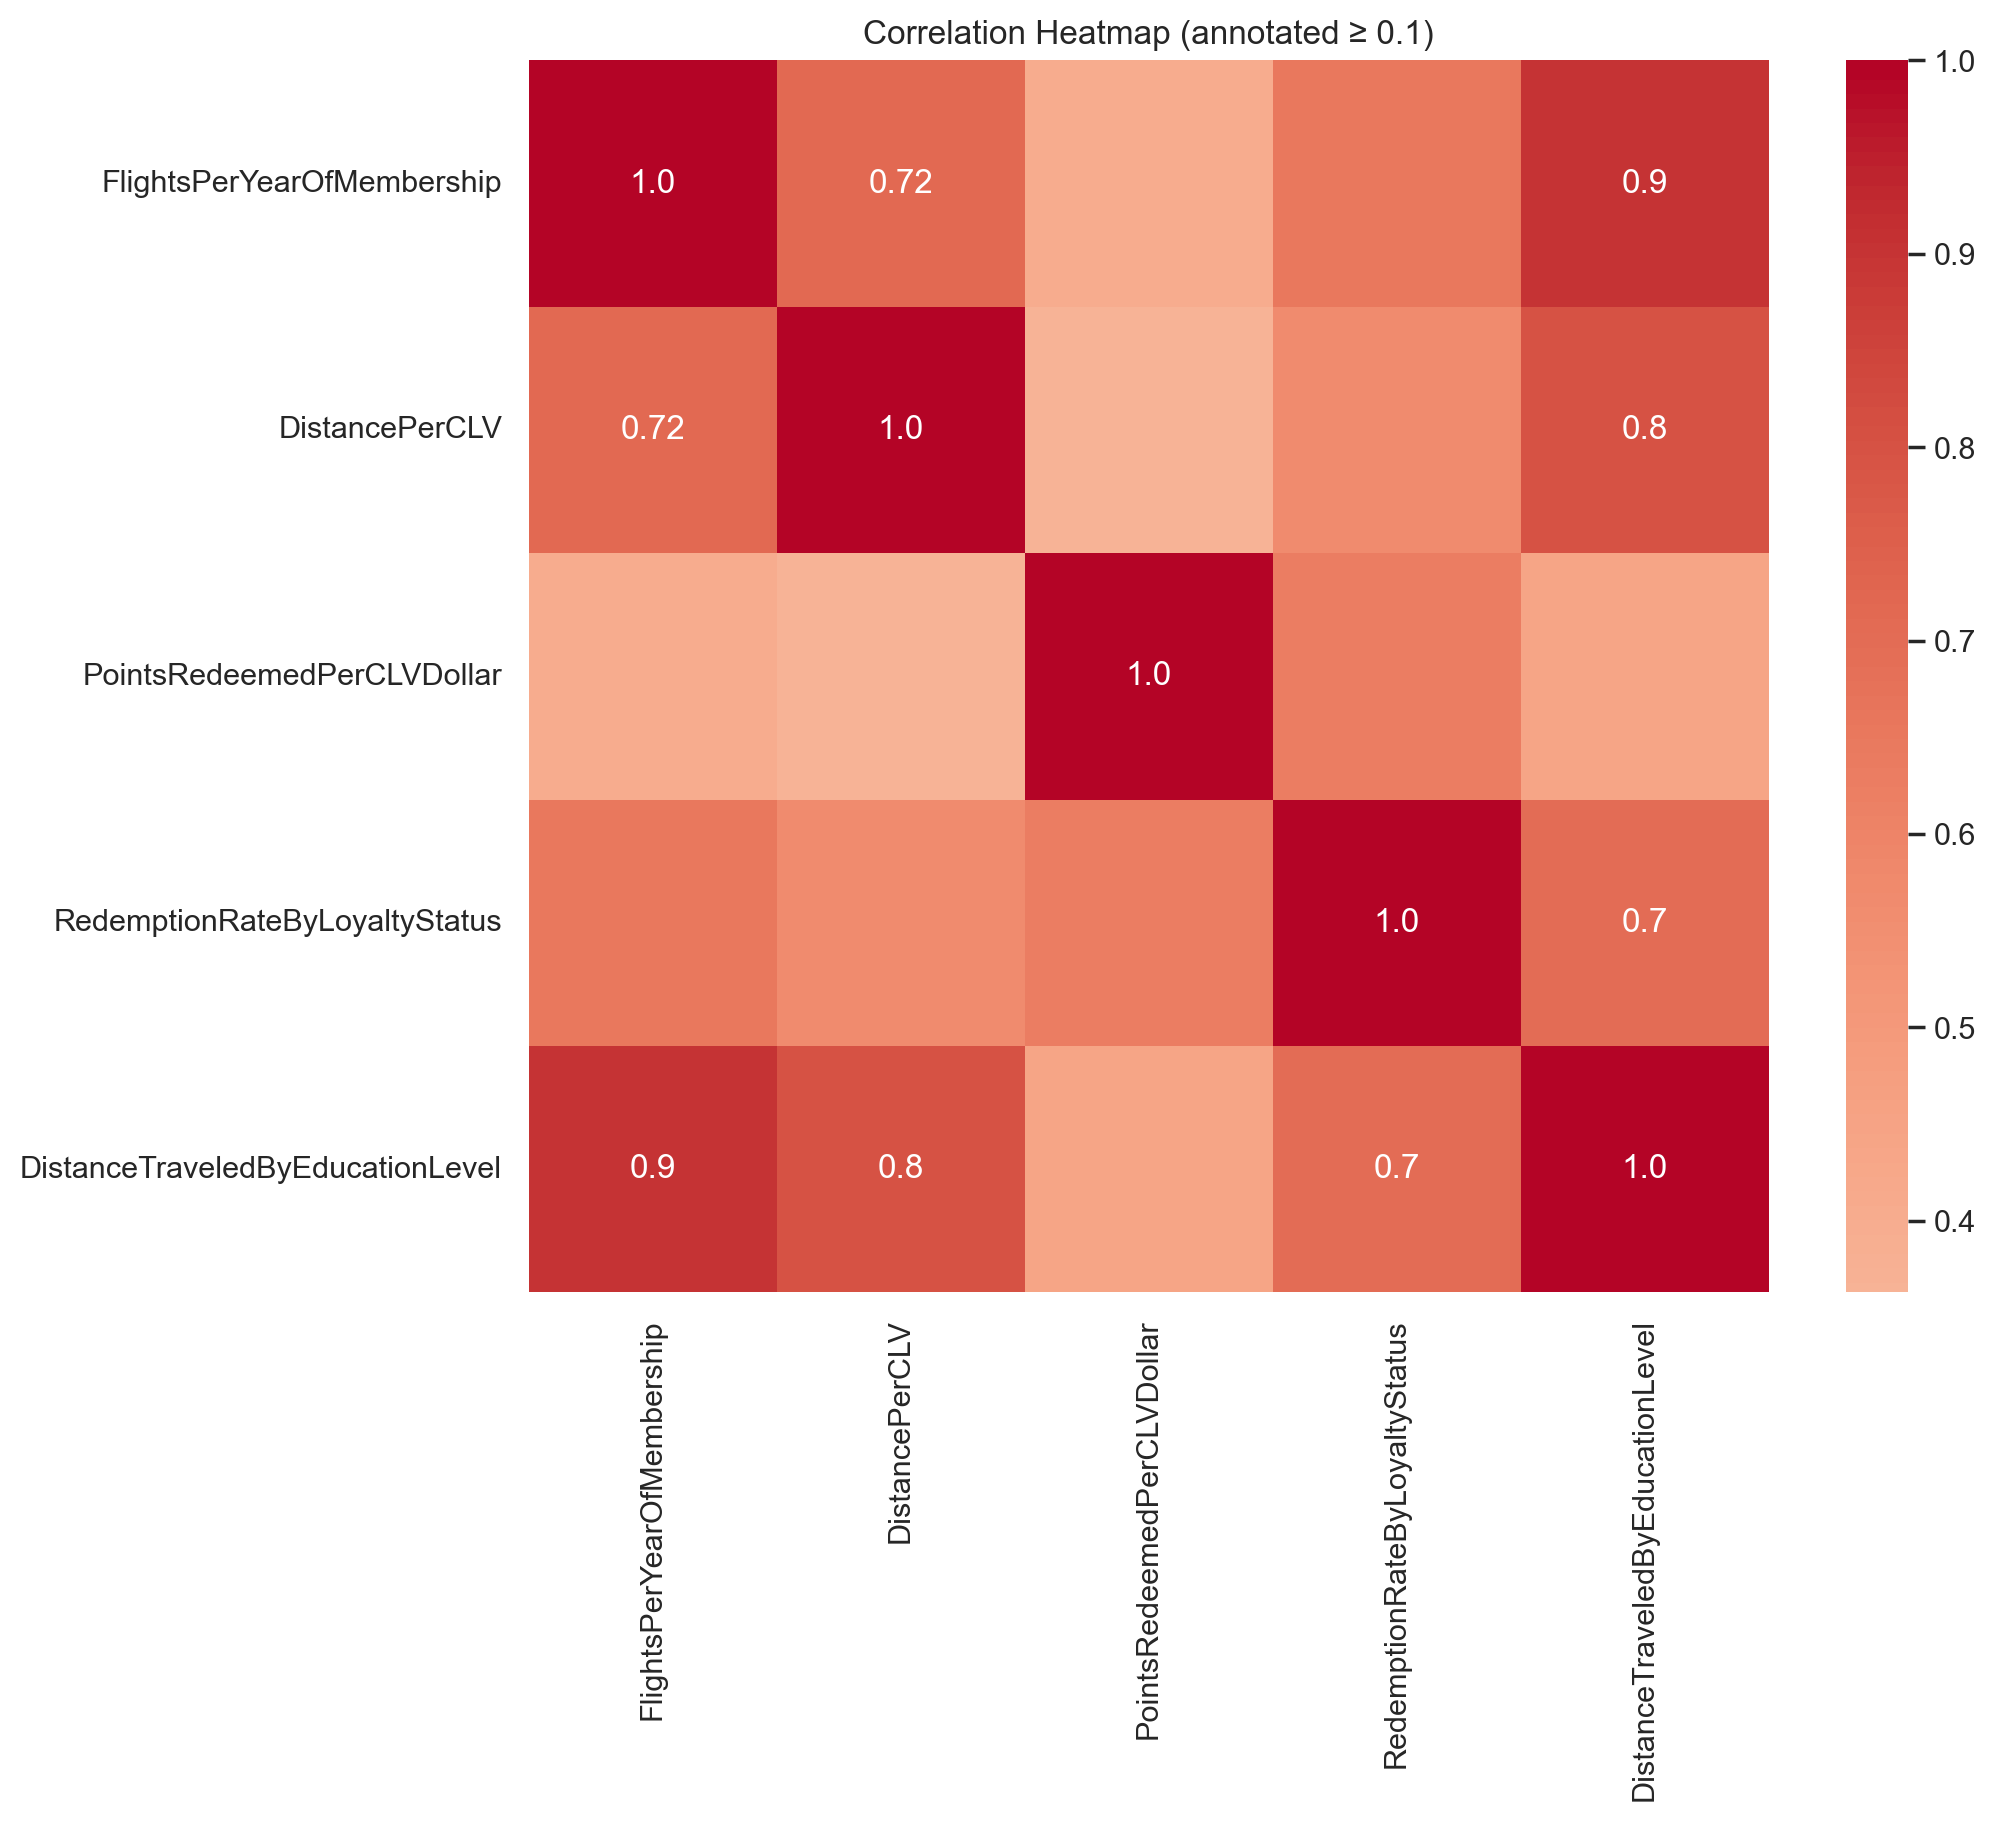

In [ ]:
dfs_merged_new = dfs_merged[['FlightsPerYearOfMembership', 
                             'DistancePerCLV', 
                             'PointsRedeemedPerCLVDollar', 
                             'RedemptionRateByLoyaltyStatus', 
                             'DistanceTraveledByEducationLevel']]

# Compute correlation matrix
corr = dfs_merged_new.corr()

# Mask values > 0.6
mask_annot = np.abs(corr.values) >= 0.7
annot = np.where(mask_annot, np.round(corr.values, 2), "")

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(data=corr, annot=annot, fmt="", center=0, cmap="coolwarm")
plt.title("Correlation Heatmap (annotated ≥ 0.1)")
plt.show()


Analysing the correlation matrix:
- `FlightsPerYearOfMembership & DistanceTraveledByEducationLevel (0.9):`This is a very strong correlation. Likely, customers who fly more also travel longer distances, and education level might be correlated with flying habits possibly because frequent flyers are often business travelers.

- `DistancePerCLV & DistanceTraveledByEducationLevel (0.8):` Customers with higher travel distances for their CLV also have higher distances associated with their education level, suggesting a socioeconomic influence on travel patterns once again.

- `FlightsPerYearOfMembership & DistancePerCLV & DistanceTraveledByEducationLevel:` All three combinations reinforce that flight frequency, travel distance, and socioeconomic status are interlinked, likely capturing overlapping behavioral patterns in high-value customer groups.

- `FlightsPerYearOfMembership & DistancePerCLV (0.72):` Frequent fliers are likely to accumulate greater distance per unit of customer lifetime value (CLV).

- `RedemptionRateByLoyaltyStatus & DistanceTraveledByEducationLevel (0.7):` Higher educational status may correlate with strategic redemption, as well-educated customers could be more aware of program benefits and optimize point/redemption behavior.

To conclude, we chose to keep FlightsPerYearOfMembership and RedemptionRateByLoyaltyStatus.

In [ ]:
dfs_merged = dfs_merged.drop(columns=[
    'DistancePerCLV',
    'PointsRedeemedPerCLVDollar',
    'DistanceTraveledByEducationLevel'])

dfs_merged_new.columns

NameError: name 'dfs_merged' is not defined

## Summary of Engineered Features

In [35]:
print(flights_new.columns)
print(customerDB_new.columns)

Index(['Loyalty#', 'TotalPointsRedeemed', 'FlightsVariance',
       'PointsRedemptionRatio', 'TotalFlightWithCompanionRatio', 'Recency',
       'DistancePerFlight'],
      dtype='object')


NameError: name 'customerDB_new' is not defined

FlightsDB:
CustomerDB: 
Merged Dataframes: FlightsPerYearOfMembership ; RedemptionRateByLoyaltyStatus

# Engineered Features' Visualisations

## FlightsDB

### Histograms

Create variable with all engineered features and another one with just the continuous ones.

In [ ]:
flightsDB_new_cont = flightsDB_expanded[['TotalDistanceKM', 'TotalPointsAccumulated', 'TotalPointsRedeemed', 'PointsRedemptionRatio', 'FlightsVariance', 'Recency', 'DistancePerFlight']]
flightsDB_new.columns


Index(['Loyalty#', 'Year', 'Month', 'YearMonthDate', 'NumFlights',
       'NumFlightsWithCompanions', 'DistanceKM', 'PointsAccumulated',
       'PointsRedeemed', 'DollarCostPointsRedeemed', 'TotalPointsRedeemed',
       'PointsRedemptionRatio', 'TotalFlightWithCompanionRatio',
       'FlightsVariance', 'Recency', 'DistancePerFlight'],
      dtype='object')

In [36]:
# Set number of rows and columns
sp_rows_FDB_new = 2
sp_cols_FDB_new = ceil(len(flightsDB_new.columns) / sp_rows_FDB_new)

# Set style
sns.set_style("white") # increase contrast

# Create figure
fig, axes = plt.subplots(sp_rows_FDB_new,
                         sp_cols_FDB_new,
                         figsize=(20, 11),
                         constrained_layout=True)

# Additional spacing between rows
fig.set_constrained_layout_pads(h_pad=.2)

# Plot data
for ax, feat in zip(axes.flatten(), flightsDB_new):
    
    sns.histplot(flightsDB_new[feat],
                 bins=10,
                 kde=(feat in flightsDB_new_cont.columns), #smooth line only for continuous variables
                 ax=ax,
                 color="#0062FF",
                 edgecolor="black")
    
    ax.set_title(feat, fontsize=18)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.set_xlabel("")

# Global title
plt.suptitle("Metric Variables' Histograms",
             fontsize=25,
             fontweight="bold",
             y=1.05)

# Save figure
os.makedirs(os.path.join('..', 'figures', 'eda'), exist_ok=True)
fig.savefig(os.path.join('..', 'figures', 'eda', 'flightsDB_new_features.png'),
            dpi=200)

# display output
plt.show()


NameError: name 'flightsDB_new' is not defined

From the histograms, we can take the following conclusions:
- `TotalFlights:` Most customers take between 50-250 flights, with a long tail of higher flyers suggesting a small elite frequent traveler segment.
- `TotalFlightsWithCompanions:` Most flights are solo, but a notable portion of travelers often fly with companions, illustrated by the slight right skew.
- `TotalDistanceKM:` Distance traveled shows moderate right skew, with a concentration of customers in the 200,000-500,000km range and a small group traveling much farther.
- `TotalPointsAccumulated:` Points distribution mirrors distance, with accumulation peaking around 25,000-60,000 points and a tail of high earners.
- `TotalPointsRedeemed:` Majority redeem few points, but a subset frequently redeems large amounts, indicating diverse redemption behaviors.
- `PointsRedemptionRatio:` This ratio is heavily right-skewed, meaning most customers redeem few points relative to what they earn, with rare cases of extreme redemption.
- `TotalFlightWithCompanionRatio:` Most customers have a companion ratio between 0.2 and 0.6, suggesting that flying with others is not the norm but still common.
- `FlightsVariance:` Flight count variance clusters between 10 and 35, implying moderate regularity for most customers with a subset showing erratic patterns.
- `Recency:` The majority have recent activity (low recency values), but there's a tail indicating dormant or less engaged customers.
- `DistancePerFlight:` Distance per flight is highly right-skewed, with most customers taking shorter flights but a small group consistently traveling longer distances.

### Boxplot

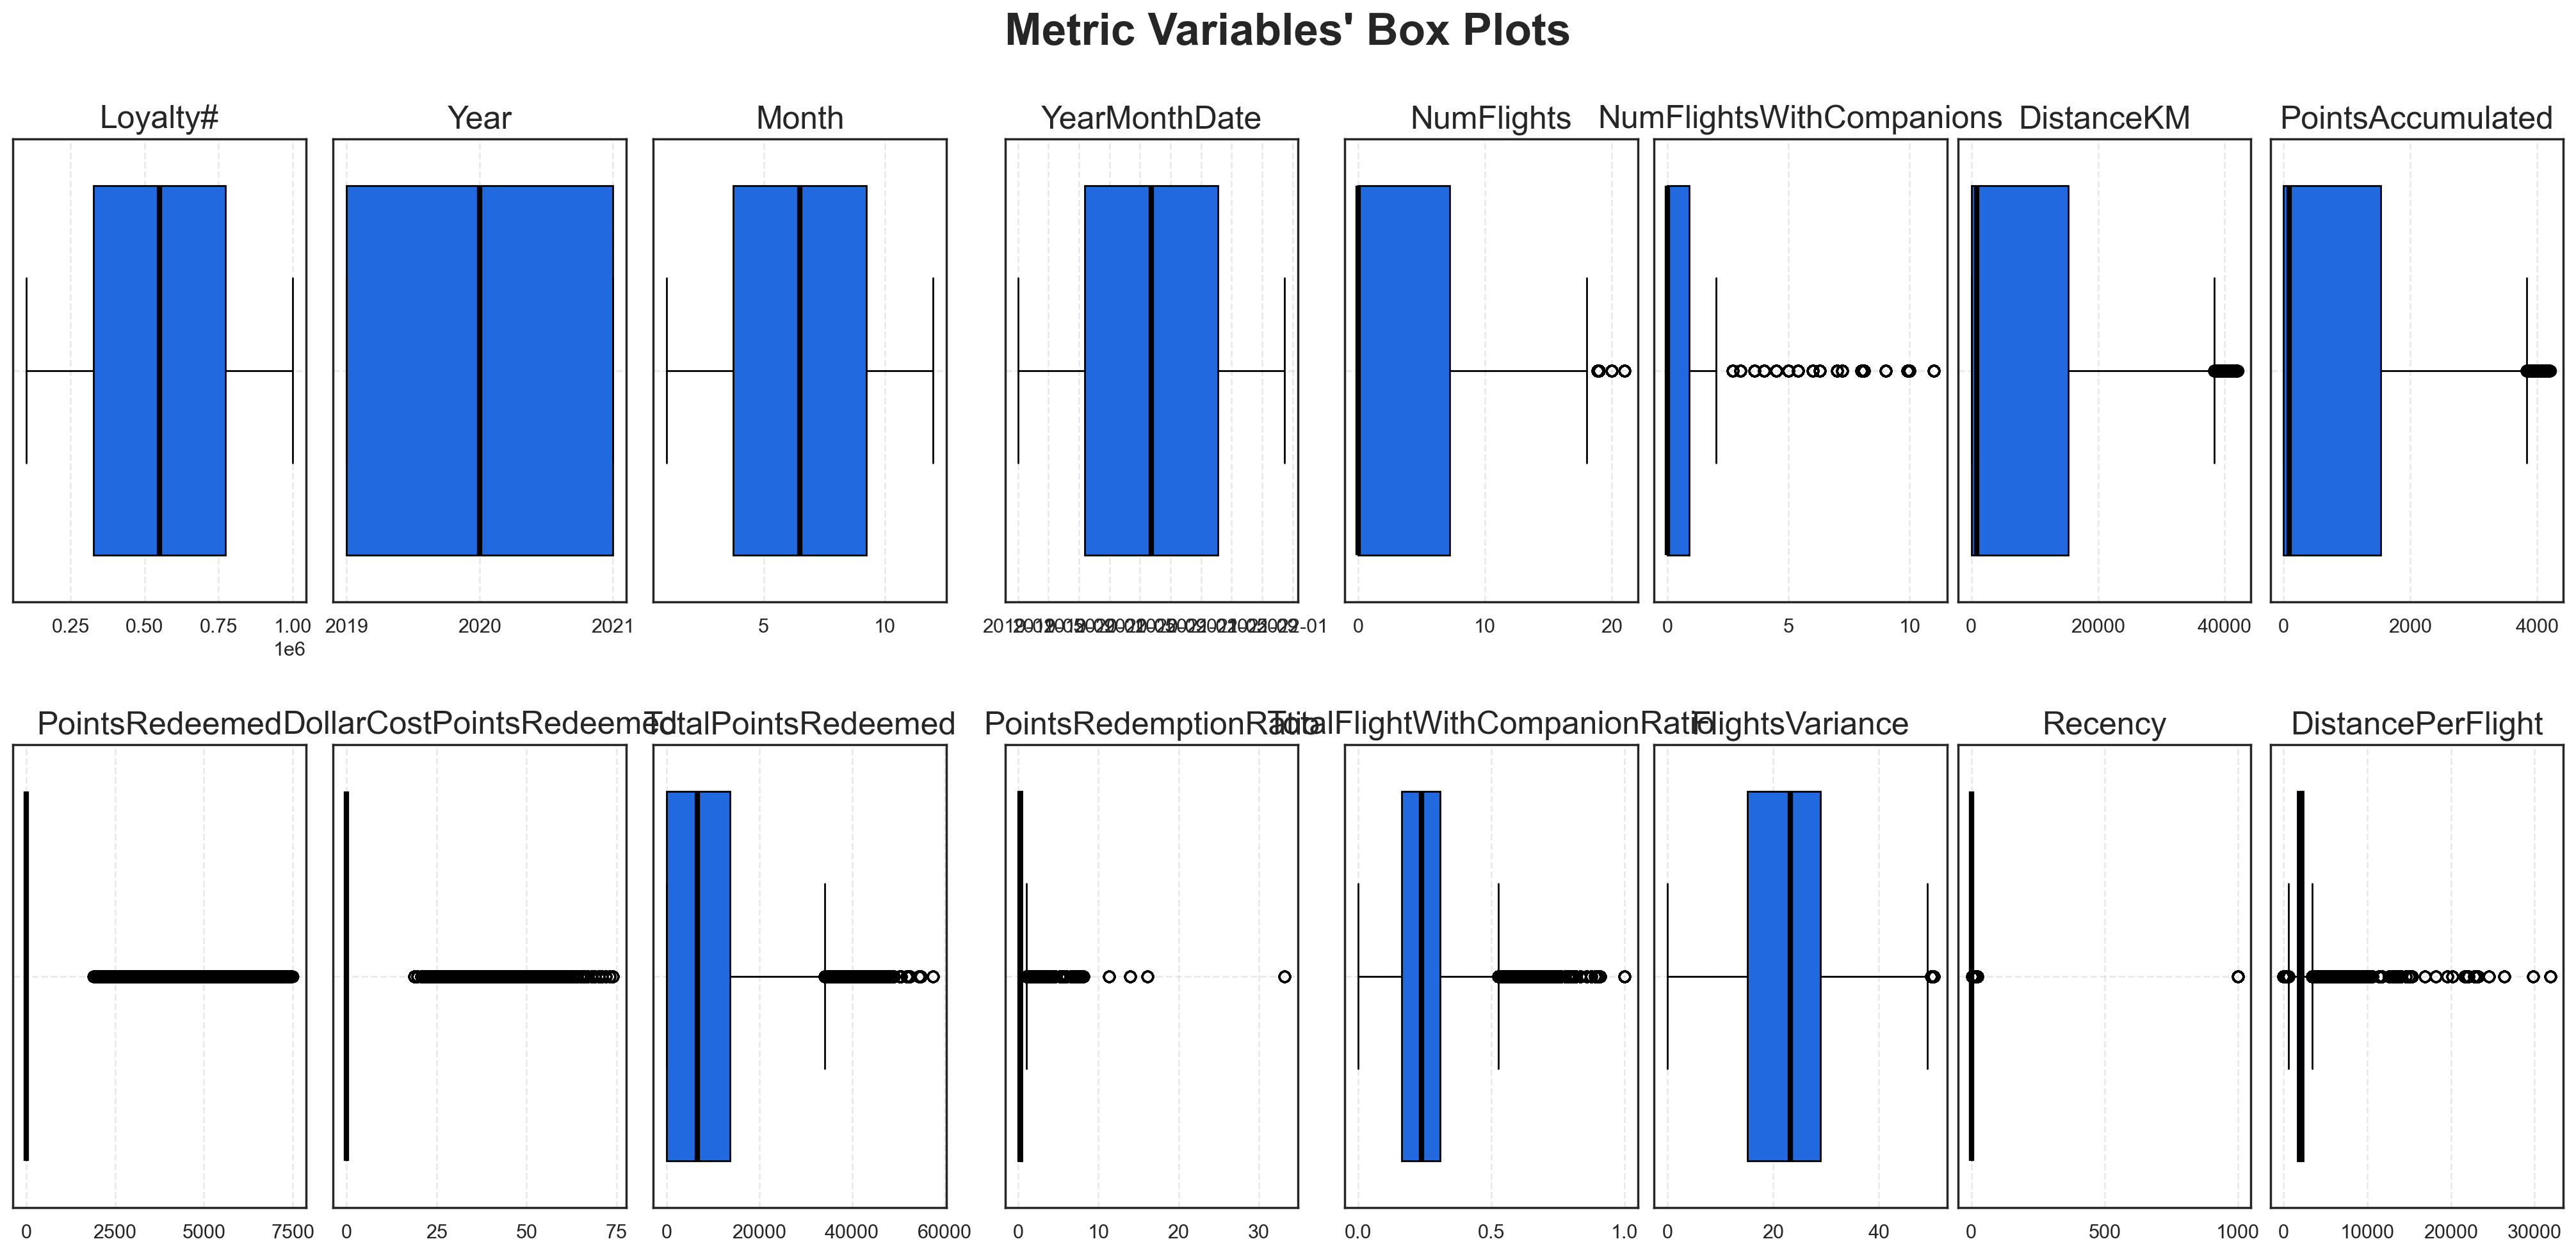

In [ ]:
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows_FDB_new, 
                         sp_cols_FDB_new, 
                         figsize=(20, 10),
                         constrained_layout=True) # Adjust automatically spacing between subplot and labels 

# Increase vertical space between rows
fig.set_constrained_layout_pads(h_pad=.2)

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), flightsDB_new): 
    sns.boxplot(x=flightsDB_new[feat], ax=ax,
                # Set inside color to blue
                color="#0062FF",
                # Set line colors to black
                boxprops=dict(edgecolor="black"),
                whiskerprops=dict(color="black"),
                capprops=dict(color="black"),
                medianprops=dict(color="black", linewidth=3),
                flierprops=dict(markeredgecolor="black"))
    
    # Put grid with low opacity and dashed line so it's visible, but not distracting
    ax.grid(True, linestyle="--", alpha=0.4)

    # Put title of each graph with bigger font
    ax.set_title(feat, fontsize=18)

    # Hide x label since we already have the boxlplot title at the top
    ax.set_xlabel("")
    
# Layout
# Add title and make it bigger
plt.suptitle("Metric Variables' Box Plots", 
             fontsize = 25, fontweight="bold")

# Create the folder '../figures/eda' if it doesn't already exist
os.makedirs(os.path.join('..', 'figures', 'eda'), exist_ok=True)

# Save figure to a png file in the folder created before
plt.savefig(os.path.join('..', 'figures', 'eda', 'numeric_variables_boxplots.png'), dpi=200)

# Show plot
plt.show()

From the boxplots we take these conclusions:
- `TotalFlights:` There is a broad range in flight counts, with the majority of customers clustered below 250 flights and many high-value outliers above this range.
- `TotalFlightsWithCompanions:` Most customers fly solo or with few companions, and there are a number of outliers who frequently travel with others.
- `TotalDistanceKM:` Travel distances show moderate spread with many customers staying below 600,000 km, though extreme travelers create distinct upper outliers.
- `TotalPointsAccumulated:` Most customers accumulate under 60,000 points, but the distribution includes many upper-end outliers, indicating a segment of heavy earners.
- `TotalPointsRedeemed:` A large proportion of customers redeem relatively few points, while significant outliers redeem high amounts.
- `PointsRedemptionRatio:` The redemption ratio is tightly concentrated for most, though there are several outliers redeeming points at much higher ratios.
- `TotalFlightWithCompanionRatio:` The companion ratio centers around 0.3 to 0.7 for most, but there is a noticeable spread with some edge outliers.
- `FlightsVariance:` Flight counts are fairly consistent among most customers, with moderate spread and a few outliers showing highly inconsistent travel patterns.
- `Recency:` Most customers have recent transactions, but there are many outliers with very high recency values, indicating inactive accounts.
- `DistancePerFlight:` The vast majority take short flights per trip, but there is a heavy right-skew with frequent long-haul travelers as outliers.

In [ ]:
flightsDB.describe().T

,count,mean,min,25%,50%,75%,max,std
Year,608436.0,2020.0,2019.0,2019.0,2020.0,2021.0,2021.0,0.816497
Month,608436.0,6.5,1.0,3.75,6.5,9.25,12.0,3.452055
YearMonthDate,608436,2020-06-16 02:40:00,2019-01-01 00:00:00,2019-09-23 12:00:00,2020-06-16 00:00:00,2021-03-08 18:00:00,2021-12-01 00:00:00,NaN
NumFlights,608436.0,3.908107,0.0,0.0,0.0,7.2,21.0,5.057889
NumFlightsWithCompanions,608436.0,0.983944,0.0,0.0,0.0,0.9,11.0,2.003785
DistanceKM,608436.0,7939.341419,0.0,0.0,856.4,15338.175,42040.0,10260.421873
PointsAccumulated,608436.0,793.777781,0.0,0.0,85.275,1533.7125,4204.0,1025.918521
PointsRedeemed,608436.0,235.251678,0.0,0.0,0.0,0.0,7496.0,983.233374
DollarCostPointsRedeemed,608436.0,2.324835,0.0,0.0,0.0,0.0,74.0,9.725168


### Scatter Plots

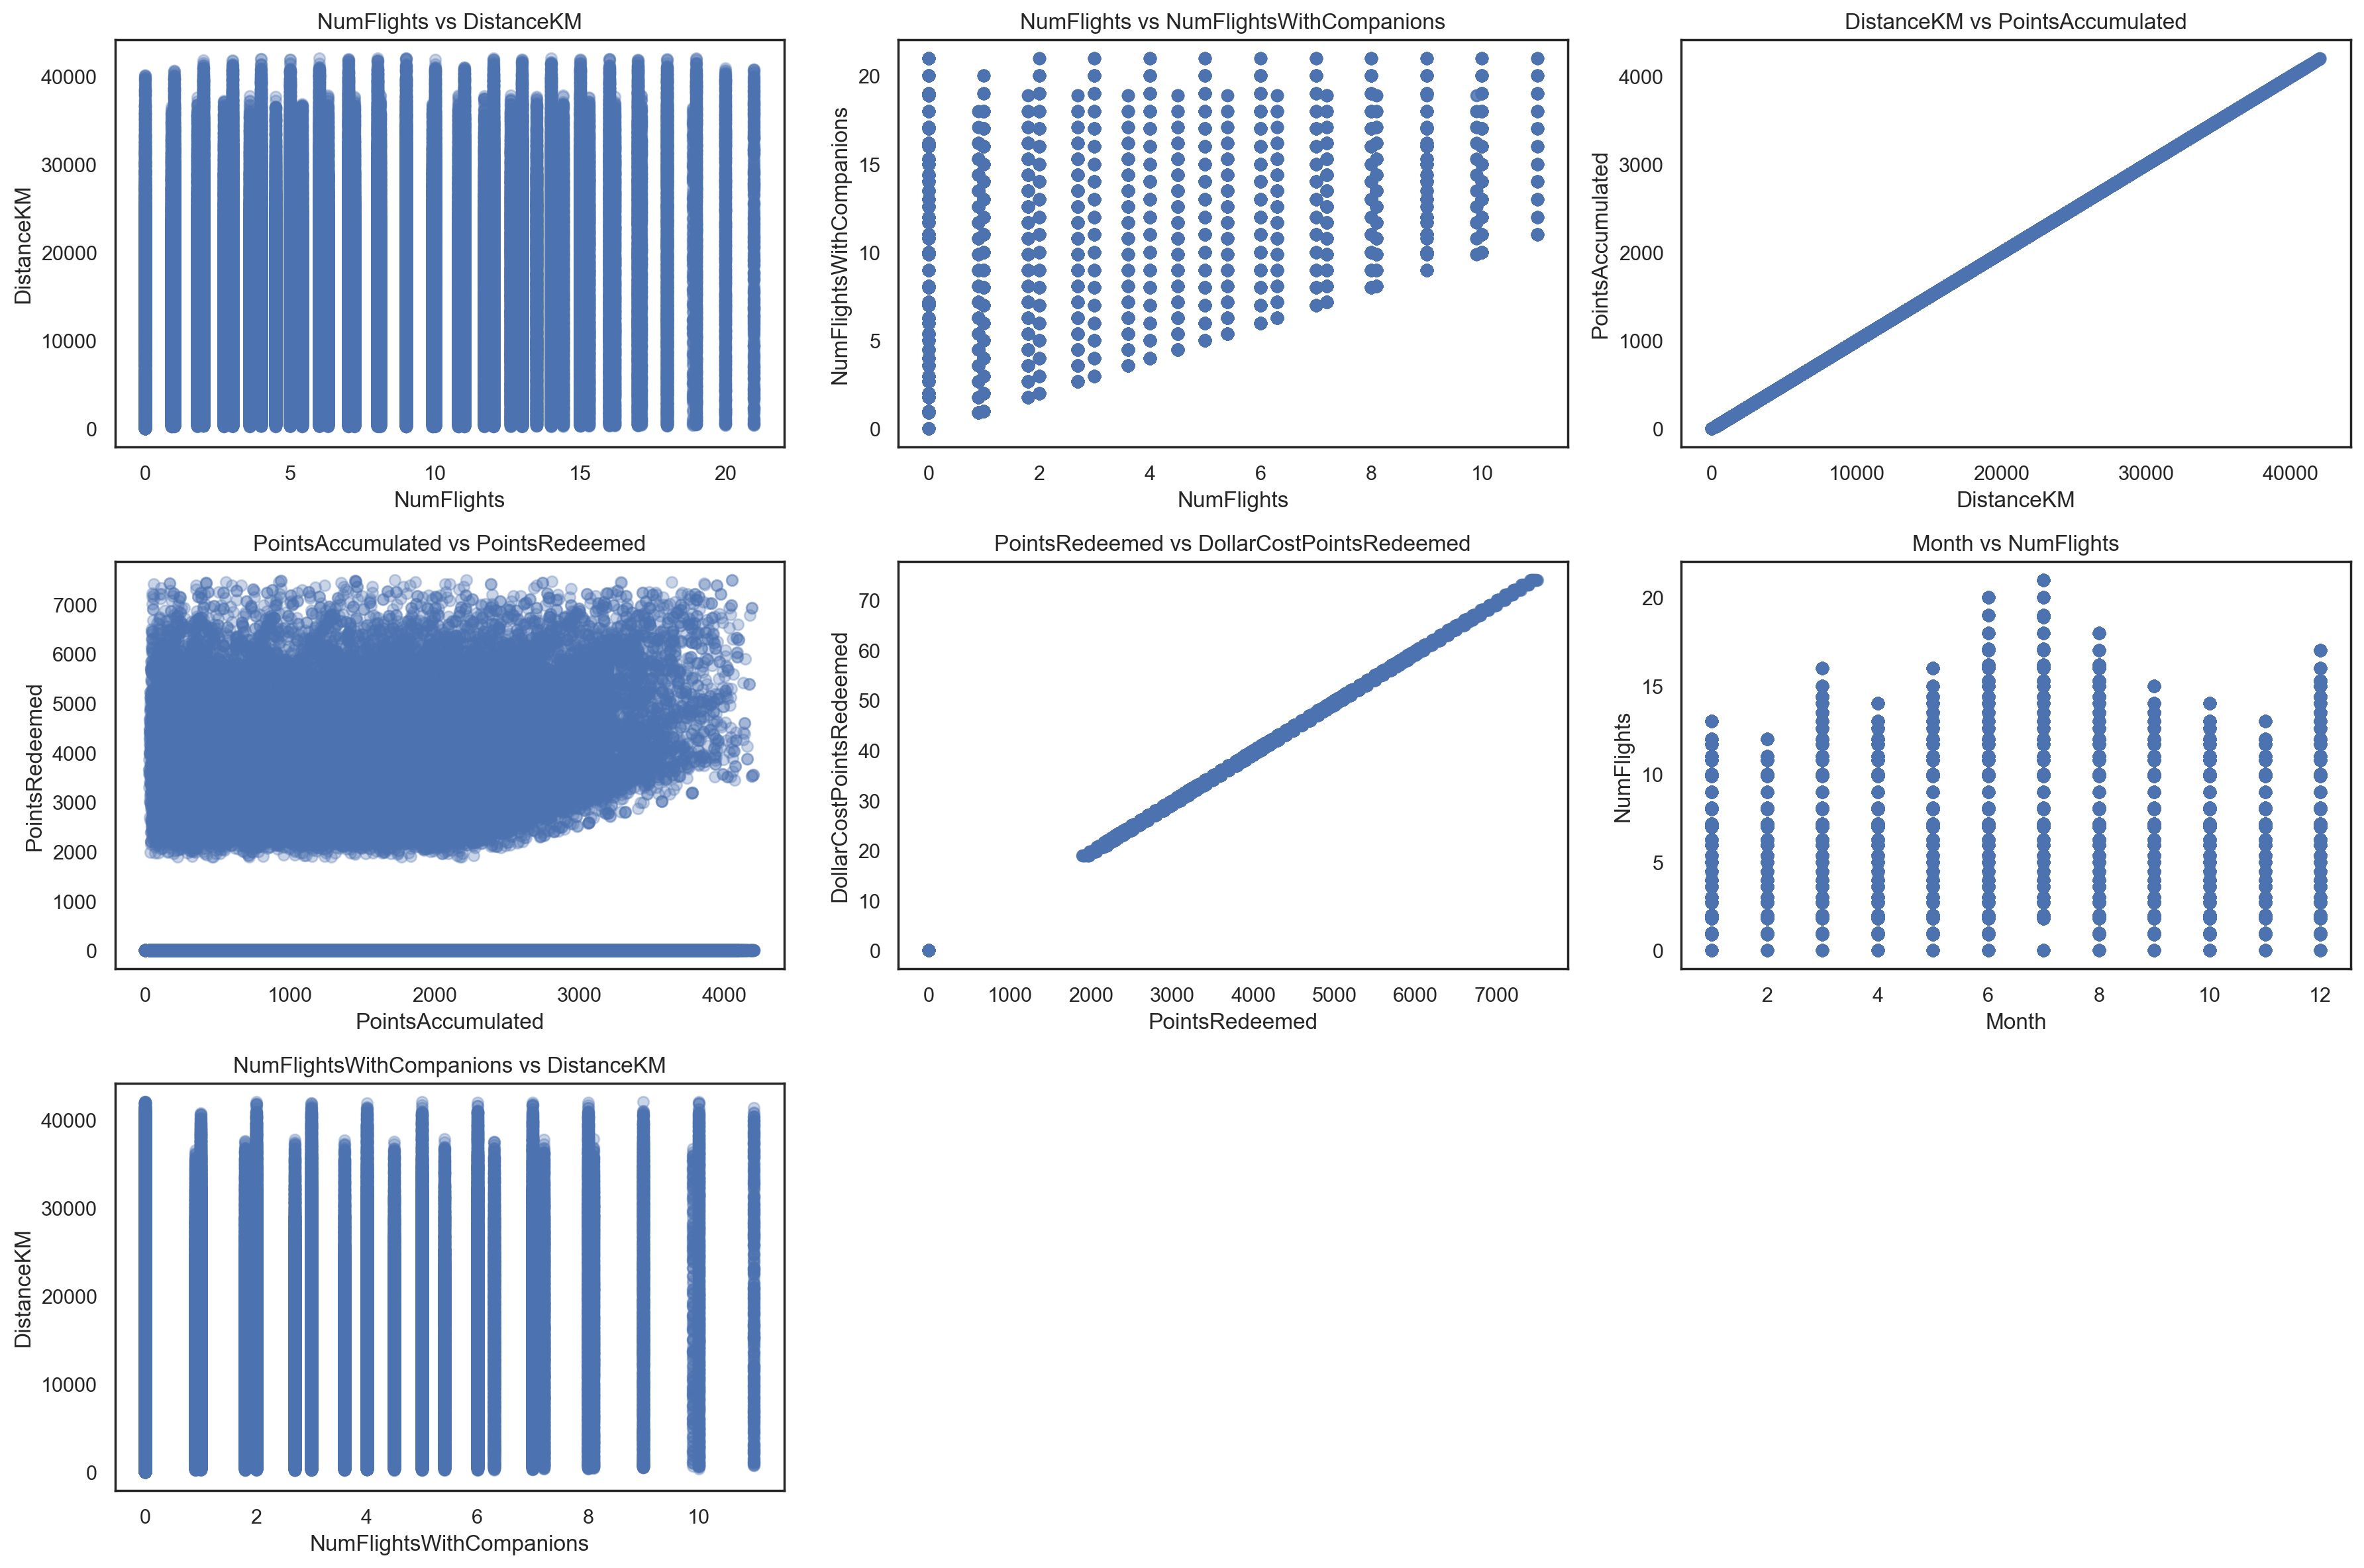

In [ ]:
# Scatterplots for selected pairs
plt.figure(figsize=(18, 12))

# 1. NumFlights vs DistanceKM
plt.subplot(3, 3, 1)
plt.scatter(flightsDB_expanded["NumFlights"], flightsDB_expanded["DistanceKM"], alpha=0.3)
plt.title("NumFlights vs DistanceKM")
plt.xlabel("NumFlights")
plt.ylabel("DistanceKM")

# 2. NumFlightsWithCompanions vs NumFlights
plt.subplot(3, 3, 2)
plt.scatter(flightsDB_expanded["NumFlightsWithCompanions"], flightsDB_expanded["NumFlights"], alpha=0.3)
plt.title("NumFlights vs NumFlightsWithCompanions")
plt.xlabel("NumFlights")
plt.ylabel("NumFlightsWithCompanions")

# 3. PointsAccumulated vs DistanceKM
plt.subplot(3, 3, 3)
plt.scatter(flightsDB_expanded["DistanceKM"], flightsDB_expanded["PointsAccumulated"], alpha=0.3)
plt.title("DistanceKM vs PointsAccumulated")
plt.xlabel("DistanceKM")
plt.ylabel("PointsAccumulated")

# 4. PointsRedeemed vs PointsAccumulated
plt.subplot(3, 3, 4)
plt.scatter(flightsDB_expanded["PointsAccumulated"], flightsDB_expanded["PointsRedeemed"], alpha=0.3)
plt.title("PointsAccumulated vs PointsRedeemed")
plt.xlabel("PointsAccumulated")
plt.ylabel("PointsRedeemed")

# 5. DollarCostPointsRedeemed vs PointsRedeemed
plt.subplot(3, 3, 5)
plt.scatter(flightsDB_expanded["PointsRedeemed"], flightsDB_expanded["DollarCostPointsRedeemed"], alpha=0.3)
plt.title("PointsRedeemed vs DollarCostPointsRedeemed")
plt.xlabel("PointsRedeemed")
plt.ylabel("DollarCostPointsRedeemed")

# 6. NumFlights vs Month
plt.subplot(3, 3, 6)
plt.scatter(flightsDB_expanded["Month"], flightsDB_expanded["NumFlights"], alpha=0.3)
plt.title("Month vs NumFlights")
plt.xlabel("Month")
plt.ylabel("NumFlights")

# 7. DistanceKM vs NumFlightsWithCompanions
plt.subplot(3, 3, 7)
plt.scatter(flightsDB_expanded["NumFlightsWithCompanions"], flightsDB_expanded["DistanceKM"], alpha=0.3)
plt.title("NumFlightsWithCompanions vs DistanceKM")
plt.xlabel("NumFlightsWithCompanions")
plt.ylabel("DistanceKM")

plt.tight_layout()
plt.show()


## CustomerDB

### Histograms

In [ ]:
customerDB_new.columns

Index(['IncomeBins', 'HouseholdType', 'MonthsSinceEnrollment', 'IsActive',
       'CLVBins', 'IncomeVsEducationMean', 'CLVvsCityMean'],
      dtype='object')

In [ ]:
customerDB_new_cont = customerDB_new.select_dtypes(include=[np.number]).drop(columns=['IsActive'])
customerDB_new_categ = customerDB_new.select_dtypes(exclude=[np.number])
customerDB_new_categ['IsActive'] = customerDB_new['IsActive']

Index(['IncomeBins', 'HouseholdType', 'CLVBins', 'IsActive'], dtype='object')

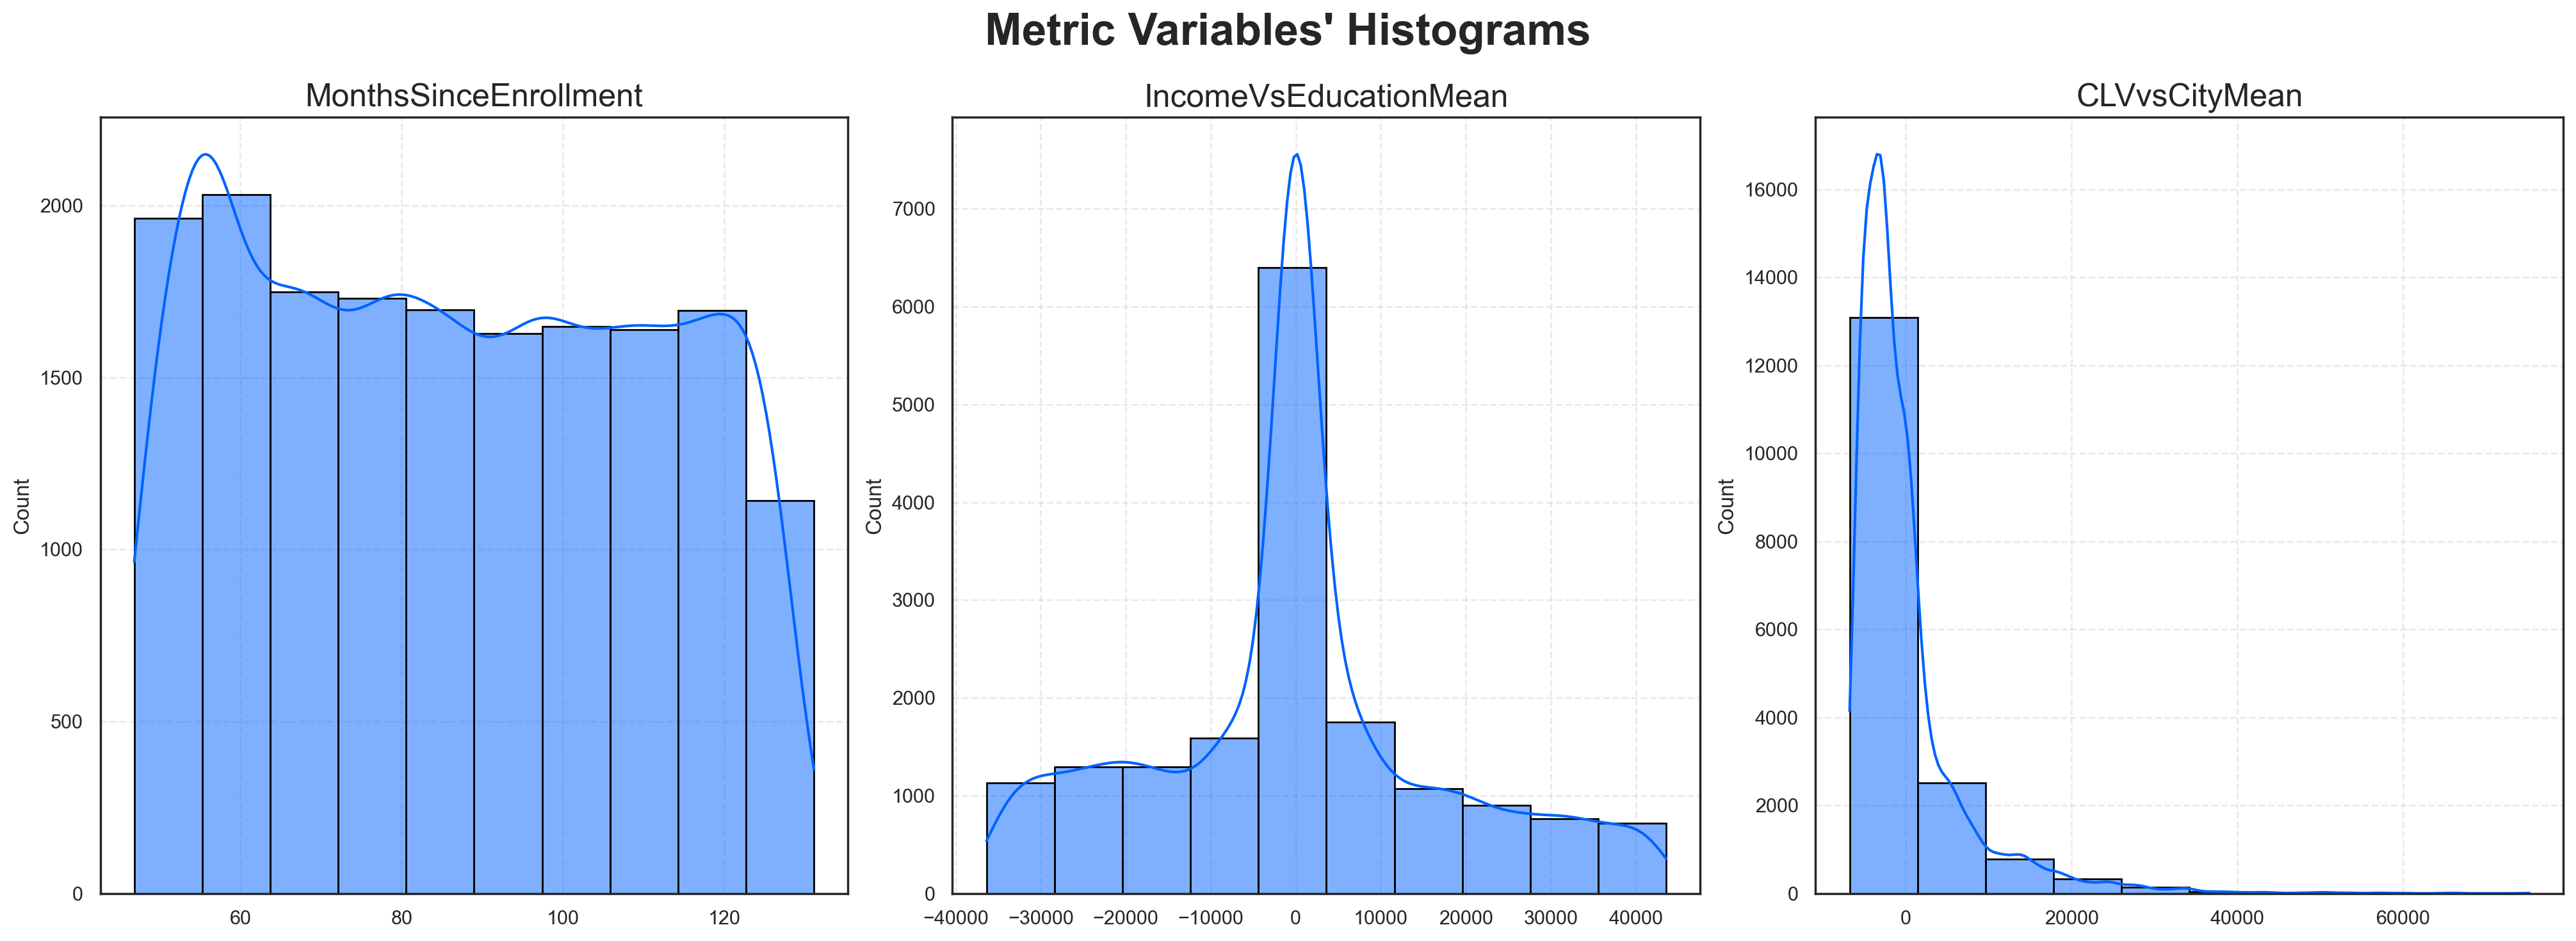

In [ ]:
# Set number of rows and columns
sp_rows_CDB_new = 1
sp_cols_CDB_new = ceil(len(customerDB_new_cont.columns) / sp_rows_CDB_new)

# Set style
sns.set_style("white") # increase contrast

# Create figure
fig, axes = plt.subplots(sp_rows_CDB_new,
                         sp_cols_CDB_new,
                         figsize=(20, 7),
                         constrained_layout=True)

# Additional spacing between rows
fig.set_constrained_layout_pads(h_pad=.2)

# Plot data
for ax, feat in zip(axes.flatten(), customerDB_new_cont):
    
    sns.histplot(customerDB_new_cont[feat],
                 bins=10,
                 kde=(feat in customerDB_new_cont.columns), #smooth line only for continuous variables
                 ax=ax,
                 color="#0062FF",
                 edgecolor="black")
    
    ax.set_title(feat, fontsize=18)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.set_xlabel("")

# Global title
plt.suptitle("Metric Variables' Histograms",
             fontsize=25,
             fontweight="bold",
             y=1.05)

# Save figure
os.makedirs(os.path.join('..', 'figures', 'eda'), exist_ok=True)
fig.savefig(os.path.join('..', 'figures', 'eda', 'customerDB_new_features.png'),
            dpi=200)

# display output
plt.show()


### Boxplots

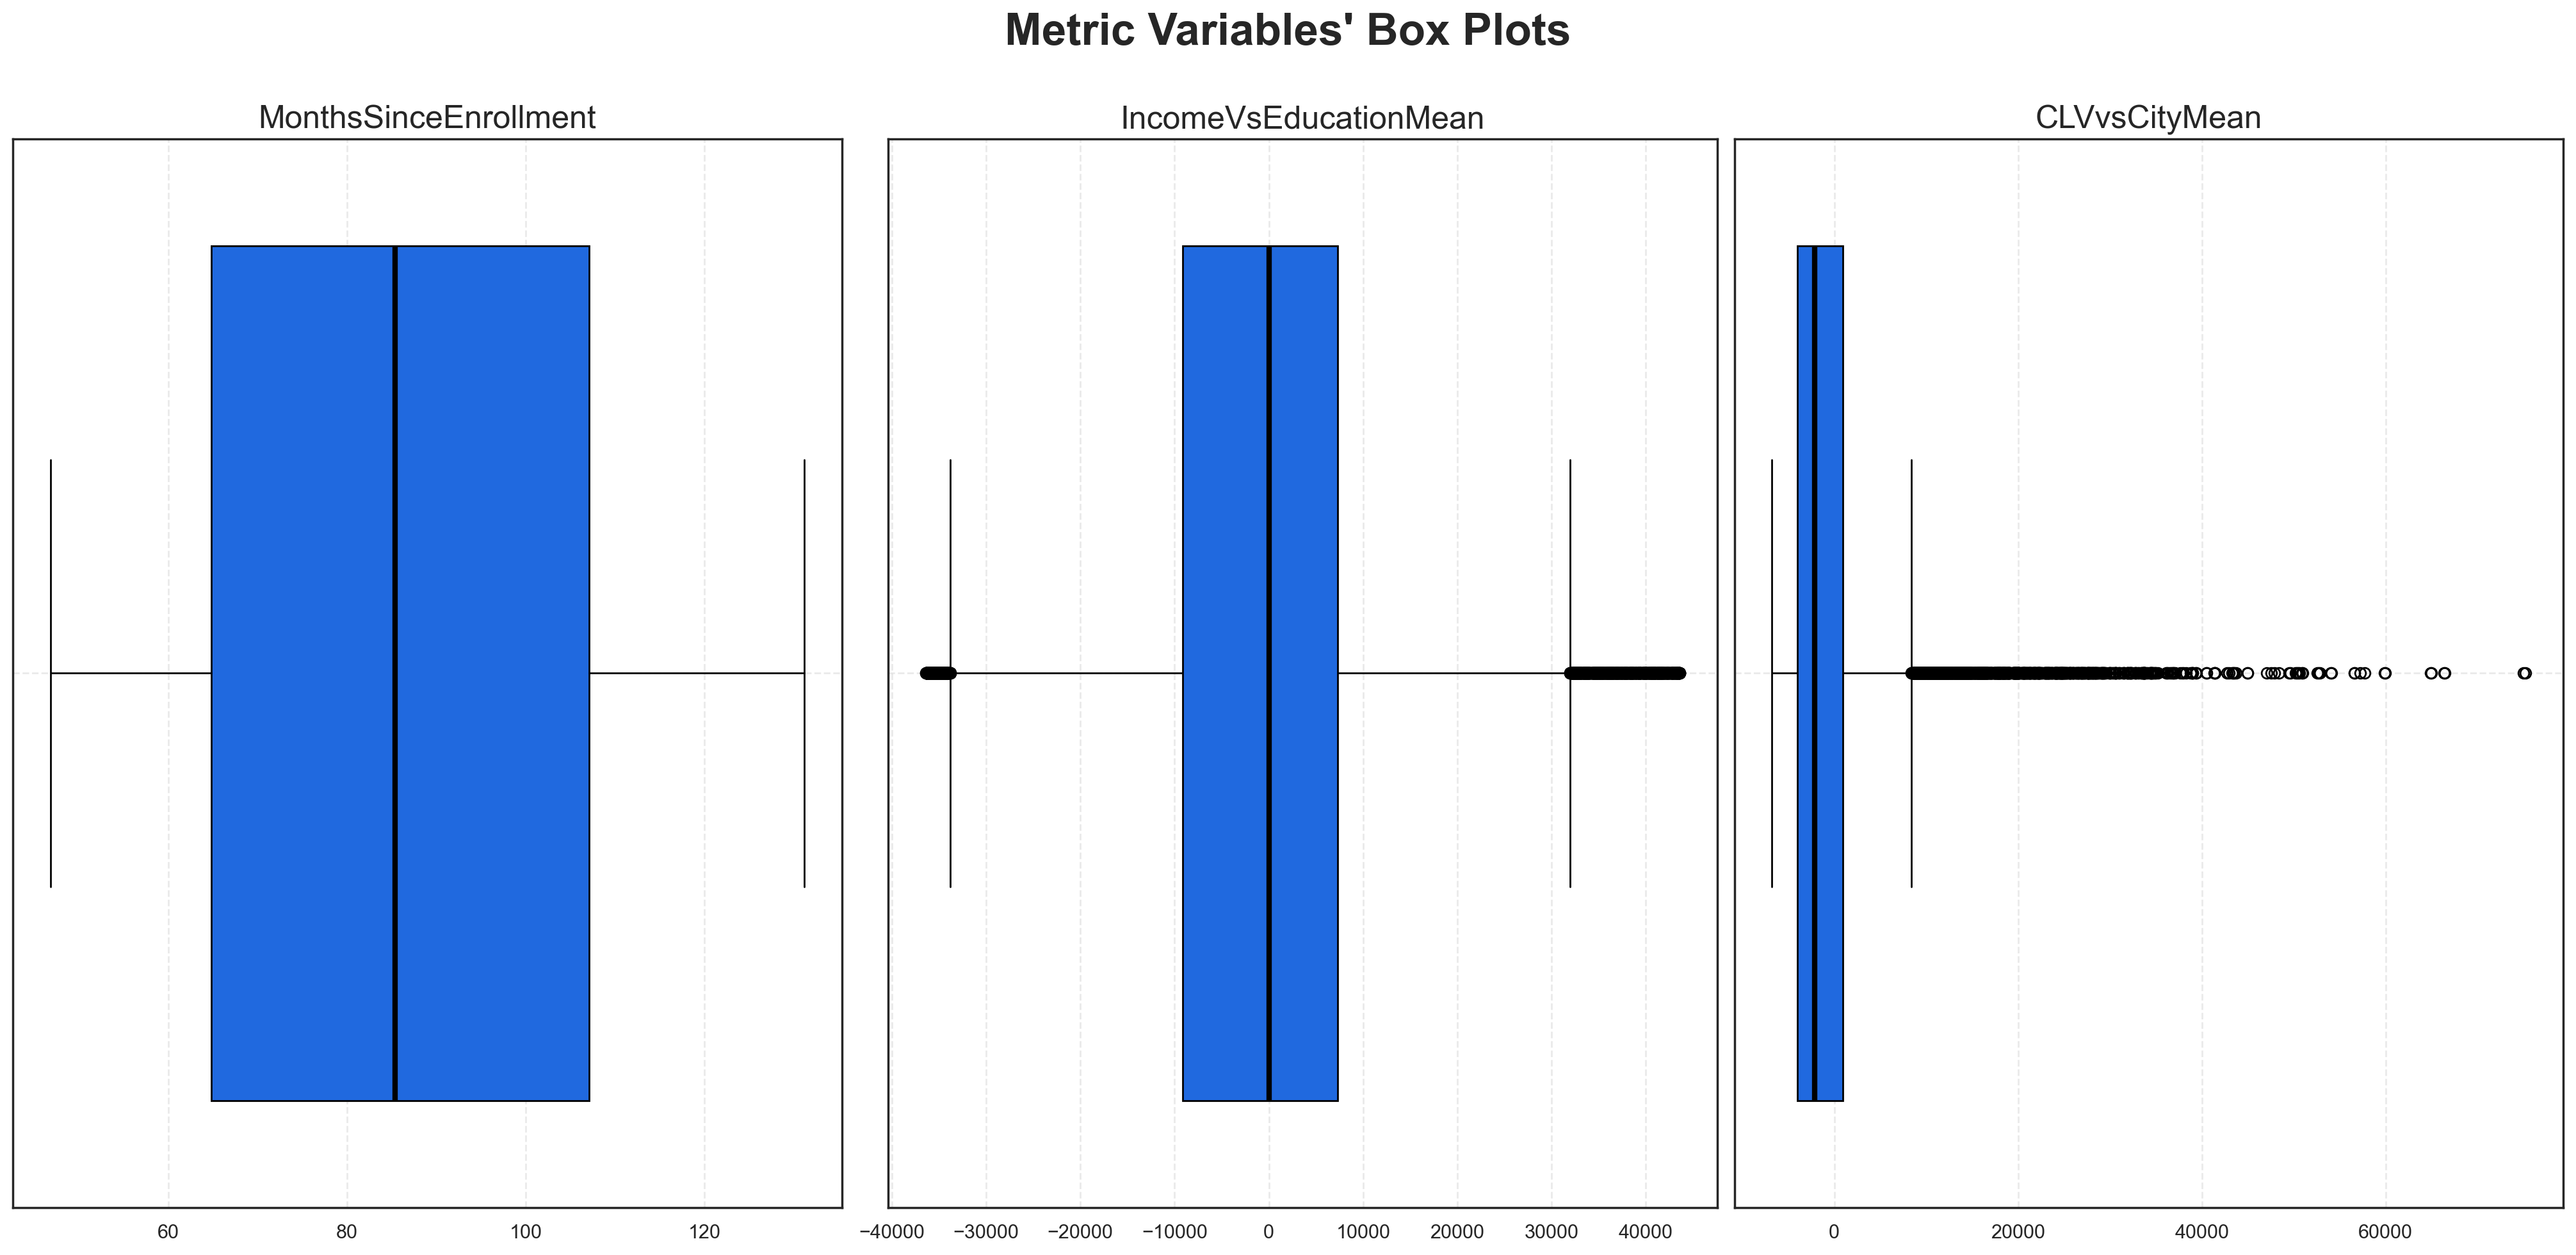

In [ ]:
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows_CDB_new, 
                         sp_cols_CDB_new, 
                         figsize=(20, 10),
                         constrained_layout=True) # Adjust automatically spacing between subplot and labels 

# Increase vertical space between rows
fig.set_constrained_layout_pads(h_pad=.2)

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), customerDB_new_cont):
    sns.boxplot(x=customerDB_new_cont[feat].reset_index(drop=True), ax=ax,
                color="#0062FF",
                boxprops=dict(edgecolor="black"),
                whiskerprops=dict(color="black"),
                capprops=dict(color="black"),
                medianprops=dict(color="black", linewidth=3),
                flierprops=dict(markeredgecolor="black"))

    
    # Put grid with low opacity and dashed line so it's visible, but not distracting
    ax.grid(True, linestyle="--", alpha=0.4)

    # Put title of each graph with bigger font
    ax.set_title(feat, fontsize=18)

    # Hide x label since we already have the boxlplot title at the top
    ax.set_xlabel("")
    
# Layout
# Add title and make it bigger
plt.suptitle("Metric Variables' Box Plots", 
             fontsize = 25, fontweight="bold")

# Create the folder '../figures/eda' if it doesn't already exist
os.makedirs(os.path.join('..', 'figures', 'eda'), exist_ok=True)

# Save figure to a png file in the folder created before
plt.savefig(os.path.join('..', 'figures', 'eda', 'numeric_variables_boxplots.png'), dpi=200)

# Show plot
plt.show()

### Bar Plots

KeyError: 'IncomeBins'

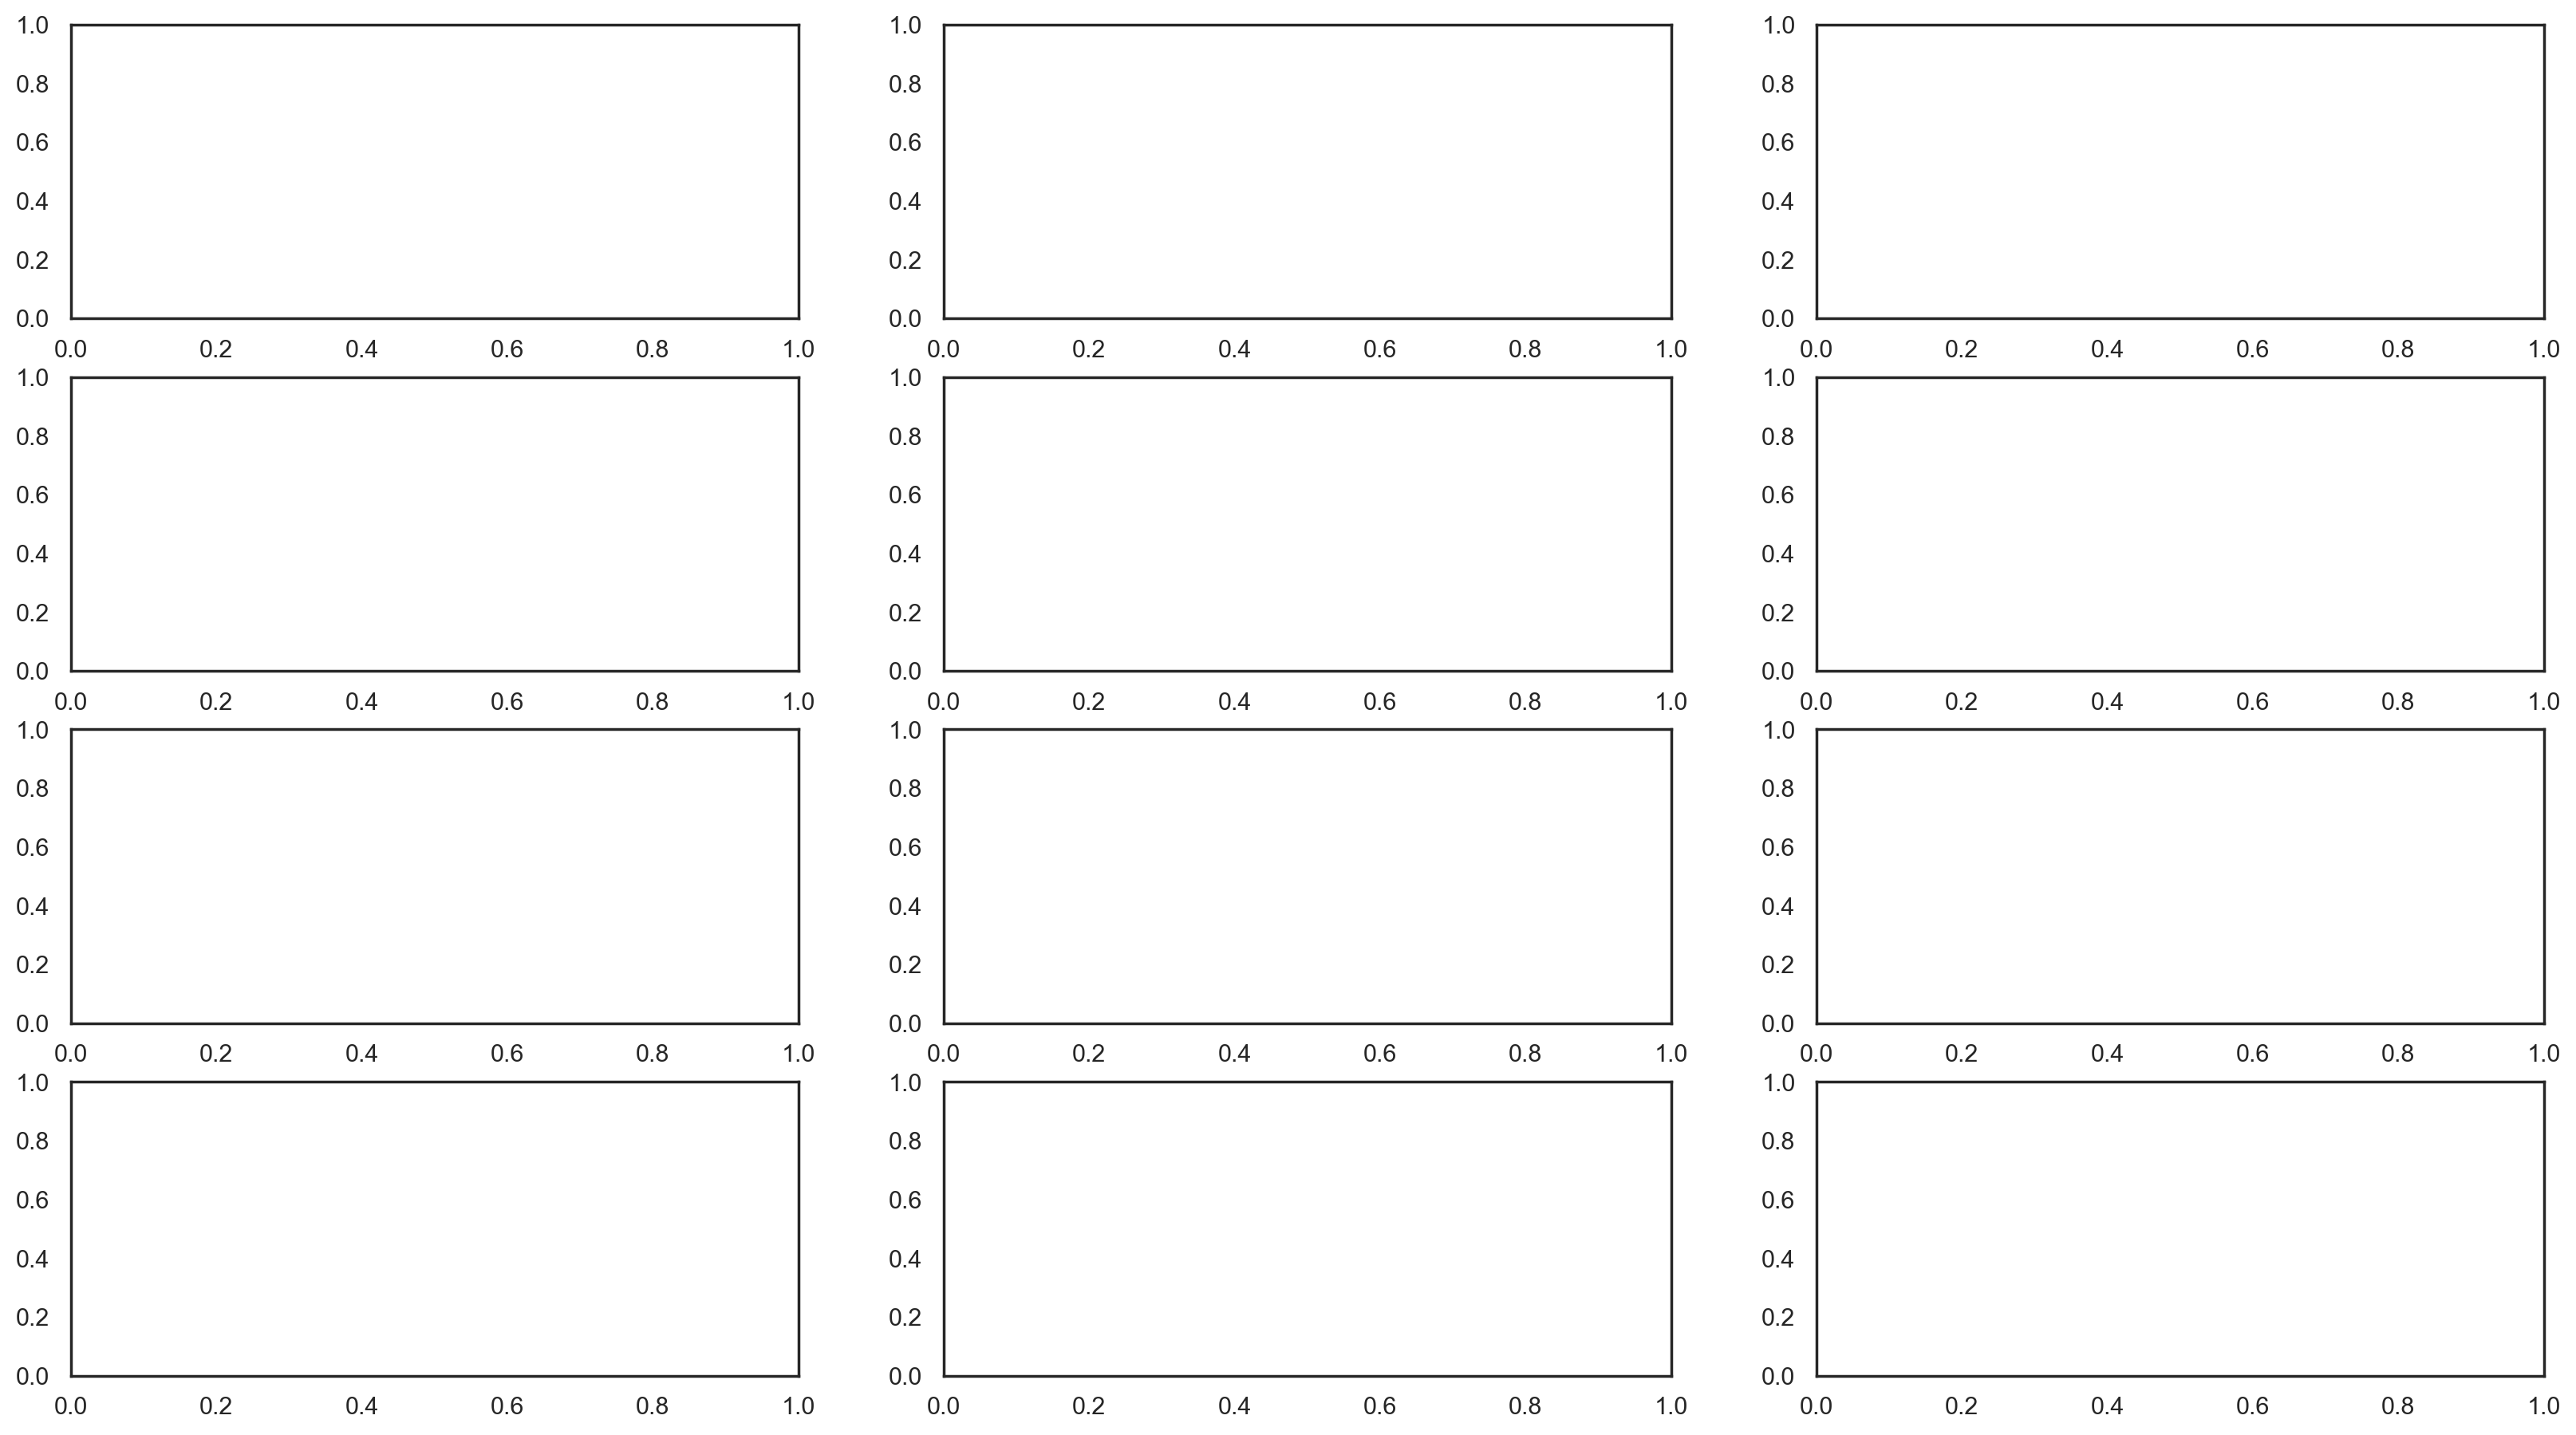

In [ ]:
# To do bar plots we use Categorical + Discrete features + dates features

sns.set(style="white")

fig, axes = plt.subplots(4, 3, figsize=(20, 11))

for ax, feat in zip(axes.flatten(), customerDB_new_categ):
    sns.countplot(x=customerDB[customerDB_new_categ][feat], ax=ax, 
                  order=customerDB[feat].value_counts().index, color="#66a4de", edgecolor="black") 
    ax.set_title(feat)
    ax.set_xlabel('') # Remove x-axis label for clarity

plt.suptitle("Bar Plots of Categorical, Discrete and Date Features", fontsize=25, fontweight="bold")
plt.tight_layout() # Adjust spacing to prevent overlap
plt.show()